# Monitored Analysis (EDA)

**파일명:** `monitored_analysis.py`

이 코드는 Monitored 데이터셋(`mon_standard.pkl`)을 로드하여  
Continuous 및 Categorical 피처를 추출하고, 전체 데이터와 웹사이트별, Trace별 통계를 산출하며  다양한 시각화를 통해 데이터 분포를 분석합니다.

1. mon_standard.pkl > array code



In [ ]:
file_path = "mon_standard.pkl"

In [ ]:
import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
with open(file_path, 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Loading datafile...
Total samples: 19000


In [ ]:
mon_data = data
print(f"데이터 타입: {type(mon_data)}")
print(f"웹사이트 수: {len(mon_data)}")
print(f"각 웹사이트별 관찰 수: {len(mon_data[0])}")

데이터 타입: <class 'dict'>
웹사이트 수: 950
각 웹사이트별 관찰 수: 20


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Continuous Features 분석
다음과 같은 연속형 수치 데이터를 분석
- 패킷 크기  
- 타임스탬프  
- 누적 크기  
- Burst  
- 패킷 간 간격(IPT)

In [ ]:

# ============================================================
# CONTINUOUS FEATURES ANALYSIS FUNCTIONS
# ============================================================

def analyze_packet_sizes(trace):
    """1. Packet sizes sequence"""
    packet_sizes = []
    for ts in trace:
        if ts < 0:
            packet_sizes.append(-512)
        elif ts > 0:
            packet_sizes.append(512)
    return packet_sizes

def analyze_timestamps(trace):
    """2. Packet timestamps sequence"""
    timestamps = [round(abs(ts), 4) for ts in trace]
    return timestamps

def analyze_cumulative_sizes(trace):
    """3. Cumulative packet sizes"""
    cumulative = []
    cumsum = 0
    for ts in trace:
        if ts < 0:
            cumsum -= 512
        elif ts > 0:
            cumsum += 512
        cumulative.append(cumsum)
    return cumulative

def analyze_bursts(trace):
    """4. Burst sequence"""
    bursts = []
    current_direction = None
    burst_sum = 0

    for ts in trace:
        direction = 1 if ts > 0 else (-1 if ts < 0 else 0)

        if direction == 0:
            continue

        if current_direction is None:
            current_direction = direction
            burst_sum = 512 if direction > 0 else -512
        elif direction == current_direction:
            burst_sum += (512 if direction > 0 else -512)
        else:
            bursts.append(burst_sum)
            current_direction = direction
            burst_sum = 512 if direction > 0 else -512

    if burst_sum != 0:
        bursts.append(burst_sum)

    return bursts

def analyze_inter_packet_times(trace):
    """5. Inter-packet times sequence"""
    timestamps = [abs(ts) for ts in trace]
    inter_times = [t2 - t1 for t1, t2 in zip(timestamps[:-1], timestamps[1:])]
    return inter_times

In [ ]:
# 샘플 데이터로 continuous features 확인
print("\nContinuous Features (첫 번째 subpage 전체):")

all_packet_sizes = []
all_timestamps = []
all_cumulative_sizes = []
all_bursts = []
all_inter_times = []


for trace_idx, trace in enumerate(mon_data[0]):
    packet_sizes = analyze_packet_sizes(trace)
    timestamps = analyze_timestamps(trace)
    cumulative_sizes = analyze_cumulative_sizes(trace)
    bursts = analyze_bursts(trace)
    ipt = analyze_inter_packet_times(trace)

    all_packet_sizes.extend(packet_sizes)
    all_timestamps.extend(timestamps)
    all_cumulative_sizes.extend(cumulative_sizes)
    all_bursts.extend(bursts)
    all_inter_times.extend(ipt)

    if trace_idx == 0:  # 첫 번째 관찰만 출력
      print(f"\nObservation {trace_idx + 1}:")
      print(f"  Trace 데이터 (처음 10개): {trace[:10]}")
      print(f"  Packet Sizes (처음 10개): {packet_sizes[:10]}")
      print(f"  Timestamps (처음 10개): {timestamps[:10]}")
      print(f"  Cumulative Sizes (처음 10개): {cumulative_sizes[:10]}")
      print(f"  Bursts (처음 10개): {bursts[:min(10, len(bursts))]}")
      print(f"  Inter-Packet Times (처음 10개): {ipt[:10]}")

num_positive = sum(1 for ps in all_packet_sizes if ps > 0)
num_negative = sum(1 for ps in all_packet_sizes if ps < 0)

# subpage 통계
print("\n첫 번째 subpage Continuous Features 통계")
print(f"Packet Sizes: {set(all_packet_sizes)}, 총 개수: {len(all_packet_sizes)}")
print(f"  +512 개수: {num_positive}")
print(f"  -512 개수: {num_negative}")
print(f"Timestamps - min: {np.min(all_timestamps):.4f}, max: {np.max(all_timestamps):.4f}, "
      f"mean: {np.mean(all_timestamps):.4f}, median: {np.median(all_timestamps):.4f}, "
      f"std: {np.std(all_timestamps):.4f}, 25%: {np.percentile(all_timestamps,25):.4f}, "
      f"75%: {np.percentile(all_timestamps,75):.4f}")
print(f"Cumulative Sizes - min: {np.min(all_cumulative_sizes)}, max: {np.max(all_cumulative_sizes)}, "
      f"mean: {np.mean(all_cumulative_sizes):.2f}, std: {np.std(all_cumulative_sizes):.2f}")
print(f"Bursts - min: {np.min(all_bursts)}, max: {np.max(all_bursts)}, "
      f"mean: {np.mean(all_bursts):.2f}, std: {np.std(all_bursts):.2f}, count: {len(all_bursts)}")
print(f"Inter-Packet Times - min: {np.min(all_inter_times):.4f}, max: {np.max(all_inter_times):.4f}, "
      f"mean: {np.mean(all_inter_times):.4f}, median: {np.median(all_inter_times):.4f}, "
      f"std: {np.std(all_inter_times):.4f}, 25%: {np.percentile(all_inter_times,25):.4f}, "
      f"75%: {np.percentile(all_inter_times,75):.4f}")


Continuous Features (첫 번째 subpage 전체):

Observation 1:
  Trace 데이터 (처음 10개): [0.0, -0.14, 0.14, -0.31, 0.31, -0.51, 0.51, 0.51, -0.75, -0.75]
  Packet Sizes (처음 10개): [-512, 512, -512, 512, -512, 512, 512, -512, -512, -512]
  Timestamps (처음 10개): [0.0, 0.14, 0.14, 0.31, 0.31, 0.51, 0.51, 0.51, 0.75, 0.75]
  Cumulative Sizes (처음 10개): [0, -512, 0, -512, 0, -512, 0, 512, 0, -512]
  Bursts (처음 10개): [-512, 512, -512, 512, -512, 1024, -7168, 512, -512, 512]
  Inter-Packet Times (처음 10개): [0.14, 0.0, 0.16999999999999998, 0.0, 0.2, 0.0, 0.0, 0.24, 0.0, 0.0]

첫 번째 subpage Continuous Features 통계
Packet Sizes: {-512, 512}, 총 개수: 20314
  +512 개수: 1940
  -512 개수: 18374
Timestamps - min: 0.0000, max: 28.7700, mean: 6.3367, median: 5.3600, std: 3.5604, 25%: 4.5100, 75%: 6.9300
Cumulative Sizes - min: -620544, max: 512, mean: -255242.78, std: 183528.60
Bursts - min: -39936, max: 4096, mean: -3387.36, std: 7206.66, count: 2484
Inter-Packet Times - min: 0.0000, max: 5.9100, mean: 0.0128, median: 0.00

## 1-1. 전체 데이터에서 Continuous Features 통계

In [ ]:
# 전체 데이터에서 continuous features 통계
print("\n전체 Continuous Features 통계:")

all_packet_sizes = []
all_timestamps = []
all_cumulative_sizes = []
all_bursts = []
num_bursts_list = []
all_inter_times = []

for website_id in mon_data.keys():
    for observation in mon_data[website_id]:
        ps = analyze_packet_sizes(observation)
        ts = analyze_timestamps(observation)
        cs = analyze_cumulative_sizes(observation)
        bs = analyze_bursts(observation)
        ipt = analyze_inter_packet_times(observation)

        all_packet_sizes.extend(ps)
        all_timestamps.extend(ts)
        all_cumulative_sizes.extend(cs)
        all_bursts.extend(bs)
        num_bursts_list.append(len(bs))
        all_inter_times.extend(ipt)

num_positive = sum(1 for ps in all_packet_sizes if ps > 0)
num_negative = sum(1 for ps in all_packet_sizes if ps < 0)

print(f"Packet Sizes: {set(all_packet_sizes)}, 총 개수: {len(all_packet_sizes)}")
print(f"  +512 개수: {num_positive}")
print(f"  -512 개수: {num_negative}")
print(f"Timestamps - min: {np.min(all_timestamps):.4f}, max: {np.max(all_timestamps):.4f}, "
      f"mean: {np.mean(all_timestamps):.4f}, median: {np.median(all_timestamps):.4f}, "
      f"std: {np.std(all_timestamps):.4f}, 25%: {np.percentile(all_timestamps,25):.4f}, "
      f"75%: {np.percentile(all_timestamps,75):.4f}")
print(f"Cumulative Sizes - min: {np.min(all_cumulative_sizes)}, max: {np.max(all_cumulative_sizes)}, "
      f"mean: {np.mean(all_cumulative_sizes):.2f}, std: {np.std(all_cumulative_sizes):.2f}")
print(f"Bursts - min: {np.min(all_bursts)}, max: {np.max(all_bursts)}, "
      f"mean: {np.mean(all_bursts):.2f}, std: {np.std(all_bursts):.2f}, count: {len(all_bursts)}")
print(f"Inter-Packet Times - min: {np.min(all_inter_times):.4f}, max: {np.max(all_inter_times):.4f}, "
      f"mean: {np.mean(all_inter_times):.4f}, median: {np.median(all_inter_times):.4f}, "
      f"std: {np.std(all_inter_times):.4f}, 25%: {np.percentile(all_inter_times,25):.4f}, "
      f"75%: {np.percentile(all_inter_times,75):.4f}")

summary_dict = {
    "Metric": [
        "packet_size_total",
        "packet_size_positive_count",
        "packet_size_negative_count",
        "timestamp_min",
        "timestamp_max",
        "timestamp_mean",
        "timestamp_median",
        "timestamp_std",
        "timestamp_25%",
        "timestamp_75%",
        "cumulative_min",
        "cumulative_max",
        "cumulative_mean",
        "cumulative_std",
        "bursts_min",
        "bursts_max",
        "bursts_mean",
        "bursts_std",
        "bursts_count",
        "interpackettimes_min",
        "interpackettimes_max",
        "interpackettimes_mean",
        "interpackettimes_median",
        "interpackettimes_std",
        "interpackettimes_25%",
        "interpackettimes_75%"
    ],
    "Value": [
        len(all_packet_sizes),
        num_positive,
        num_negative,
        np.min(all_timestamps),
        np.max(all_timestamps),
        np.mean(all_timestamps),
        np.median(all_timestamps),
        np.std(all_timestamps),
        np.percentile(all_timestamps, 25),
        np.percentile(all_timestamps, 75),
        np.min(all_cumulative_sizes),
        np.max(all_cumulative_sizes),
        np.mean(all_cumulative_sizes),
        np.std(all_cumulative_sizes),
        np.min(all_bursts),
        np.max(all_bursts),
        np.mean(all_bursts),
        np.std(all_bursts),
        len(all_bursts),
        np.min(all_inter_times),
        np.max(all_inter_times),
        np.mean(all_inter_times),
        np.median(all_inter_times),
        np.std(all_inter_times),
        np.percentile(all_inter_times,25),
        np.percentile(all_inter_times,75)
    ]
}

# DataFrame으로 변환
summary_df = pd.DataFrame(summary_dict)
pd.set_option('display.float_format', '{:.10f}'.format)

# 출력
print("\nContinuous Features Summary:")
print(summary_df.round(4))

# CSV로 저장
summary_df.to_csv("continuous_features_summary.csv", index=False, encoding='utf-8-sig')
print("\n'continuous_features_summary.csv' 파일로 저장 완료!")




전체 Continuous Features 통계:
Packet Sizes: {-512, 512}, 총 개수: 79568362
  +512 개수: 6611291
  -512 개수: 72957071
Timestamps - min: 0.0000, max: 86.0200, mean: 9.9932, median: 7.8300, std: 7.4545, 25%: 5.6000, 75%: 11.5500
Cumulative Sizes - min: -4813824, max: 27648, mean: -1444112.49, std: 1161144.76
Bursts - min: -54272, max: 258048, mean: -4906.74, std: 9037.26, count: 6922928
Inter-Packet Times - min: 0.0000, max: 64.9200, mean: 0.0067, median: 0.0000, std: 0.2229, 25%: 0.0000, 75%: 0.0000

Continuous Features Summary:
                        Metric               Value
0            packet_size_total 79568362.0000000000
1   packet_size_positive_count  6611291.0000000000
2   packet_size_negative_count 72957071.0000000000
3                timestamp_min        0.0000000000
4                timestamp_max       86.0200000000
5               timestamp_mean        9.9932000000
6             timestamp_median        7.8300000000
7                timestamp_std        7.4545000000
8               

## 1-2. 전체 데이터에서 Continuous Features 시각화

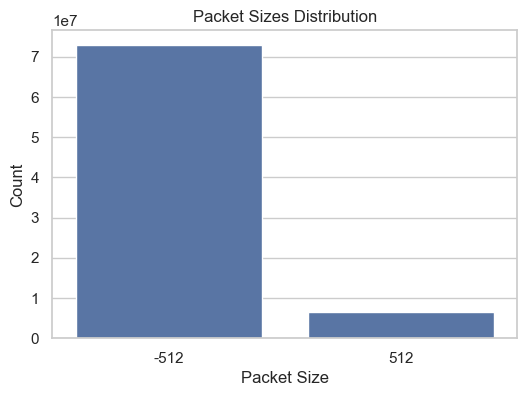

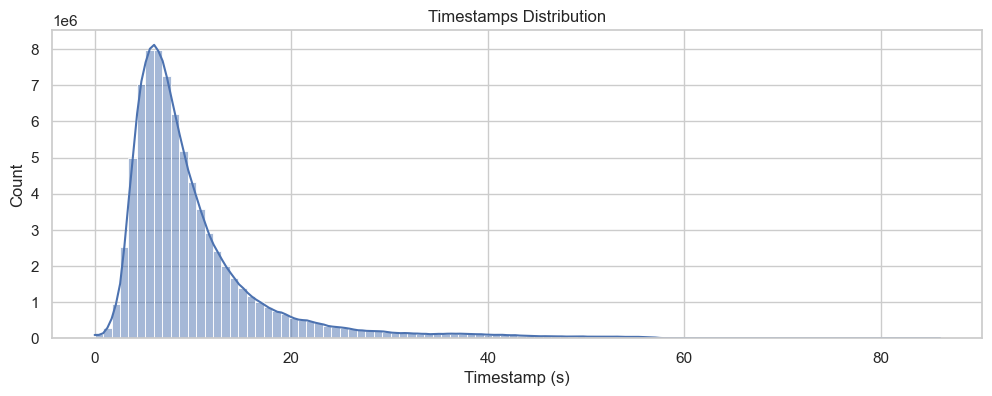

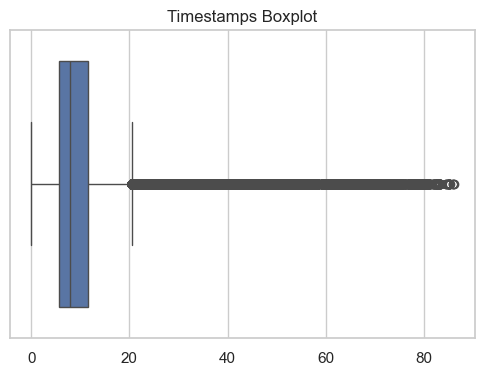

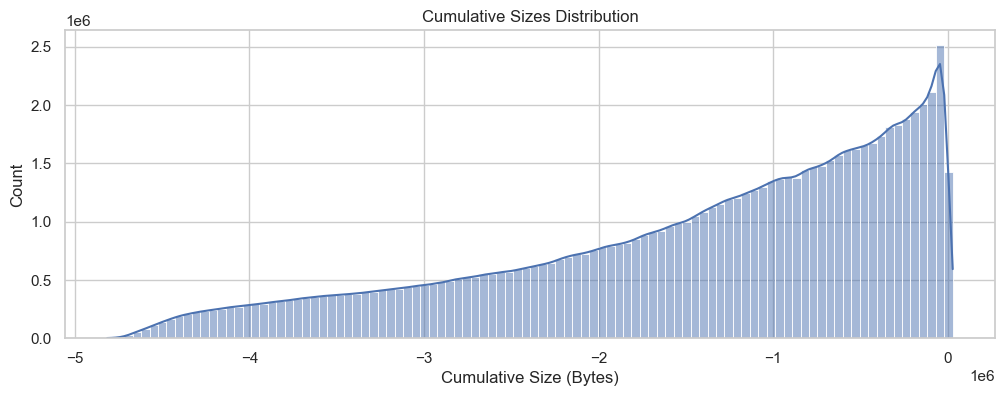

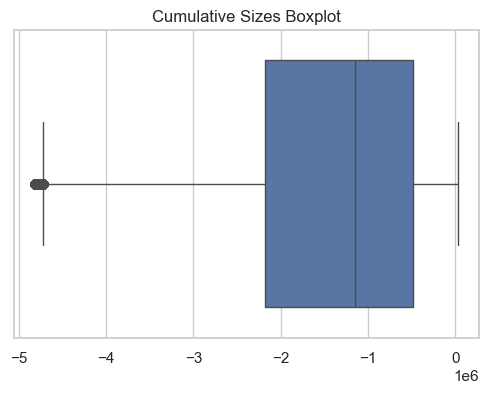

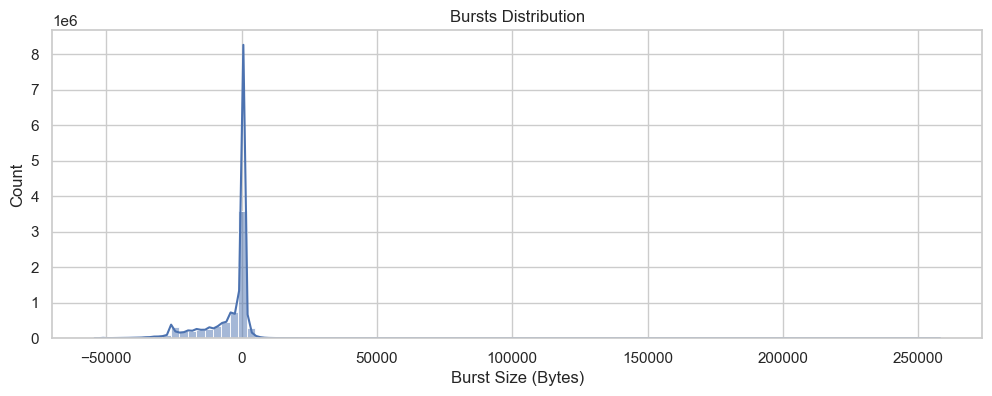

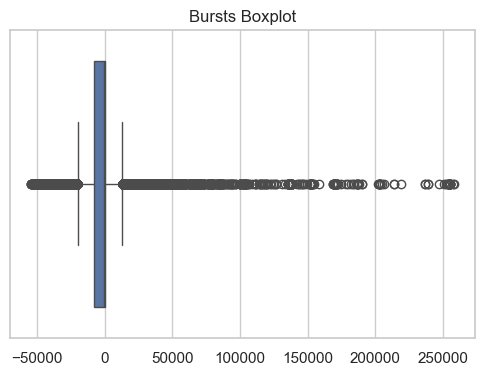

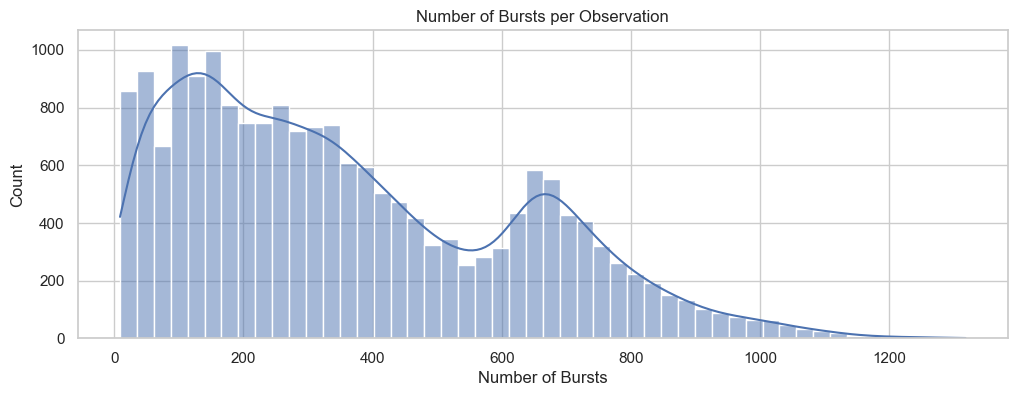

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 시각화 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ===========================================================
# 1. Packet Sizes
# ===========================================================
plt.figure(figsize=(6,4))
sns.countplot(x=all_packet_sizes)
plt.title("Packet Sizes Distribution")
plt.xlabel("Packet Size")
plt.ylabel("Count")
plt.show()

# ===========================================================
# 2. Timestamps
# ===========================================================
plt.figure(figsize=(12,4))
sns.histplot(all_timestamps, bins=100, kde=True)
plt.title("Timestamps Distribution")
plt.xlabel("Timestamp (s)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=all_timestamps)
plt.title("Timestamps Boxplot")
plt.show()

# ===========================================================
# 3. Cumulative Sizes
# ===========================================================
plt.figure(figsize=(12,4))
sns.histplot(all_cumulative_sizes, bins=100, kde=True)
plt.title("Cumulative Sizes Distribution")
plt.xlabel("Cumulative Size (Bytes)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=all_cumulative_sizes)
plt.title("Cumulative Sizes Boxplot")
plt.show()

# ===========================================================
# 4. Bursts
# ===========================================================
plt.figure(figsize=(12,4))
sns.histplot(all_bursts, bins=100, kde=True)
plt.title("Bursts Distribution")
plt.xlabel("Burst Size (Bytes)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=all_bursts)
plt.title("Bursts Boxplot")
plt.show()

# ===========================================================
# 5. Number of bursts per observation
# ===========================================================
plt.figure(figsize=(12,4))
sns.histplot(num_bursts_list, bins=50, kde=True)
plt.title("Number of Bursts per Observation")
plt.xlabel("Number of Bursts")
plt.ylabel("Count")
plt.show()


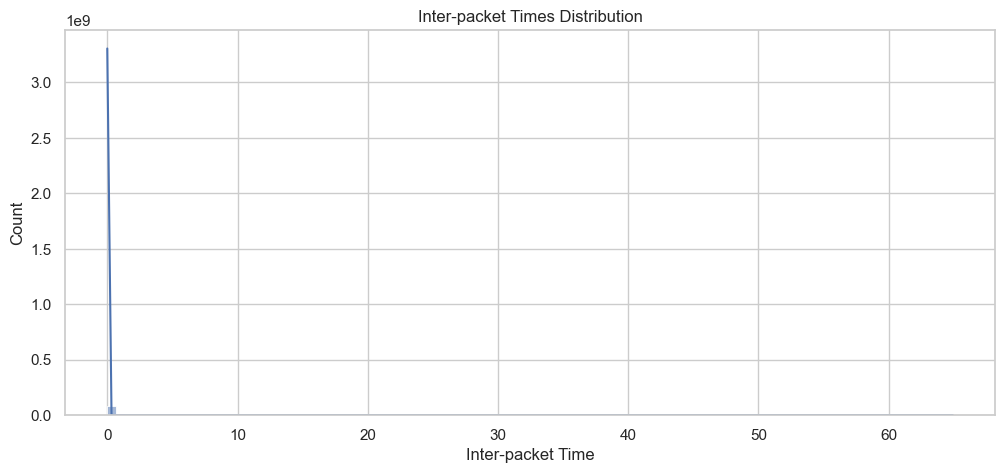

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 시각화 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ===========================================================
# 6. Inter-packet Times
# ===========================================================
plt.figure(figsize=(12,5))
sns.histplot(all_inter_times, bins=100, kde=True)
plt.title("Inter-packet Times Distribution")
plt.xlabel("Inter-packet Time")
plt.ylabel("Count")
plt.show()

## 1-3. 웹사이트별 Continuous Features 통계

In [ ]:
import pandas as pd
import numpy as np

# =================================
# 웹사이트별 Continuous Features 계산
# =================================
website_continuous = {}
for label in sorted(set(y)):
    ps_all, ts_all, cs_all, bs_all, ipt_all = [], [], [], [], []
    for i, sample in enumerate(X2):
        if y[i] == label:
            ps_all.extend(sample)
            ts_all.extend(X1[i])
            cs_all.extend(analyze_cumulative_sizes(sample))
            bs_all.extend(analyze_bursts(sample))
            ipt_all.extend(analyze_inter_packet_times(sample))
    website_continuous[label] = {
        'packet_sizes': ps_all,
        'timestamps': ts_all,
        'cumulative_sizes': cs_all,
        'bursts': bs_all,
        'inter_packet_times': ipt_all
    }

# ===============================
# 웹사이트별 통계 계산 및 저장
# ===============================
results = []
print(f"{'Label':<6} {'+ Packets':<12} {'- Packets':<12} {'TS_mean':<12} {'CS_mean':<12} {'BS_mean':<12} {'IPT_mean':<12}")
print("-" * 100)

for label, data in website_continuous.items():
    num_pos = sum(1 for x in data['packet_sizes'] if x > 0)
    num_neg = sum(1 for x in data['packet_sizes'] if x < 0)

    def stats(arr):
        if not arr:
            return (0, 0, 0, 0, 0, 0, 0, 0)
        return (
            np.min(arr),
            np.max(arr),
            np.mean(arr),
            np.median(arr),
            np.std(arr),
            np.percentile(arr, 25),
            np.percentile(arr, 75),
            len(arr)
        )

    ts_min, ts_max, ts_mean, ts_median, ts_std, ts_25, ts_75, ts_count = stats(data['timestamps'])
    cs_min, cs_max, cs_mean, cs_median, cs_std, cs_25, cs_75, cs_count = stats(data['cumulative_sizes'])
    bs_min, bs_max, bs_mean, bs_median, bs_std, bs_25, bs_75, bs_count = stats(data['bursts'])
    ipt_min, ipt_max, ipt_mean, ipt_median, ipt_std, ipt_25, ipt_75, ipt_count = stats(data['inter_packet_times'])

    print(f"{label:<6} {num_pos:<12} {num_neg:<12} {ts_mean:<12.4f} {cs_mean:<12.2f} {bs_mean:<12.2f} {ipt_mean:<12.4f}")

    results.append({
        "label": label,
        "packet_size_total": len(data['packet_sizes']),
        "packet_size_positive_count": num_pos,
        "packet_size_negative_count": num_neg,
        "timestamp_min": ts_min,
        "timestamp_max": ts_max,
        "timestamp_mean": ts_mean,
        "timestamp_median": ts_median,
        "timestamp_std": ts_std,
        "timestamp_25%": ts_25,
        "timestamp_75%": ts_75,
        "cumulative_min": cs_min,
        "cumulative_max": cs_max,
        "cumulative_mean": cs_mean,
        "cumulative_std": cs_std,
        "bursts_min": bs_min,
        "bursts_max": bs_max,
        "bursts_mean": bs_mean,
        "bursts_std": bs_std,
        "bursts_count": bs_count,
        "interpacket_min": ipt_min,
        "interpacket_max": ipt_max,
        "interpacket_mean": ipt_mean,
        "interpacket_median": ipt_median,
        "interpacket_std": ipt_std,
        "interpacket_25%": ipt_25,
        "interpacket_75%": ipt_75,
        "interpacket_count": ipt_count
})
results_df = pd.DataFrame(results)
print("\nWebsite Continuous Feature Summary:")
print(results_df.round(4))
results_df.to_csv("website_continuous_summary.csv", index=False, encoding='utf-8-sig')
print("\n'website_continuous_summary.csv' 파일로 저장 완료!")


Label  + Packets    - Packets    TS_mean      CS_mean      BS_mean      IPT_mean    
----------------------------------------------------------------------------------------------------
0      84363        907402       8.7651       -1618317.25  -5194.02     0.0000      
1      41538        397898       7.6120       -645093.93   -4876.56     0.0000      
2      51413        790053       8.7346       -1197558.79  -5505.10     0.0000      
3      55872        899774       9.2075       -1625379.85  -6292.46     0.0000      
4      39109        334809       6.7771       -582877.04   -3922.44     0.0000      
5      78913        683130       9.1939       -1006936.58  -4847.29     0.0000      
6      44233        728267       8.6662       -911638.14   -6202.74     0.0000      
7      21236        225250       5.5055       -348056.26   -5140.51     0.0000      
8      49985        539263       8.1096       -1207911.57  -4944.35     0.0000      
9      73203        1088470      9.3598       -15

## 1-4. 웹사이트별 Continuous Features 시각화


WEBSITE-LEVEL VISUALIZATION (95 Websites Comparison)


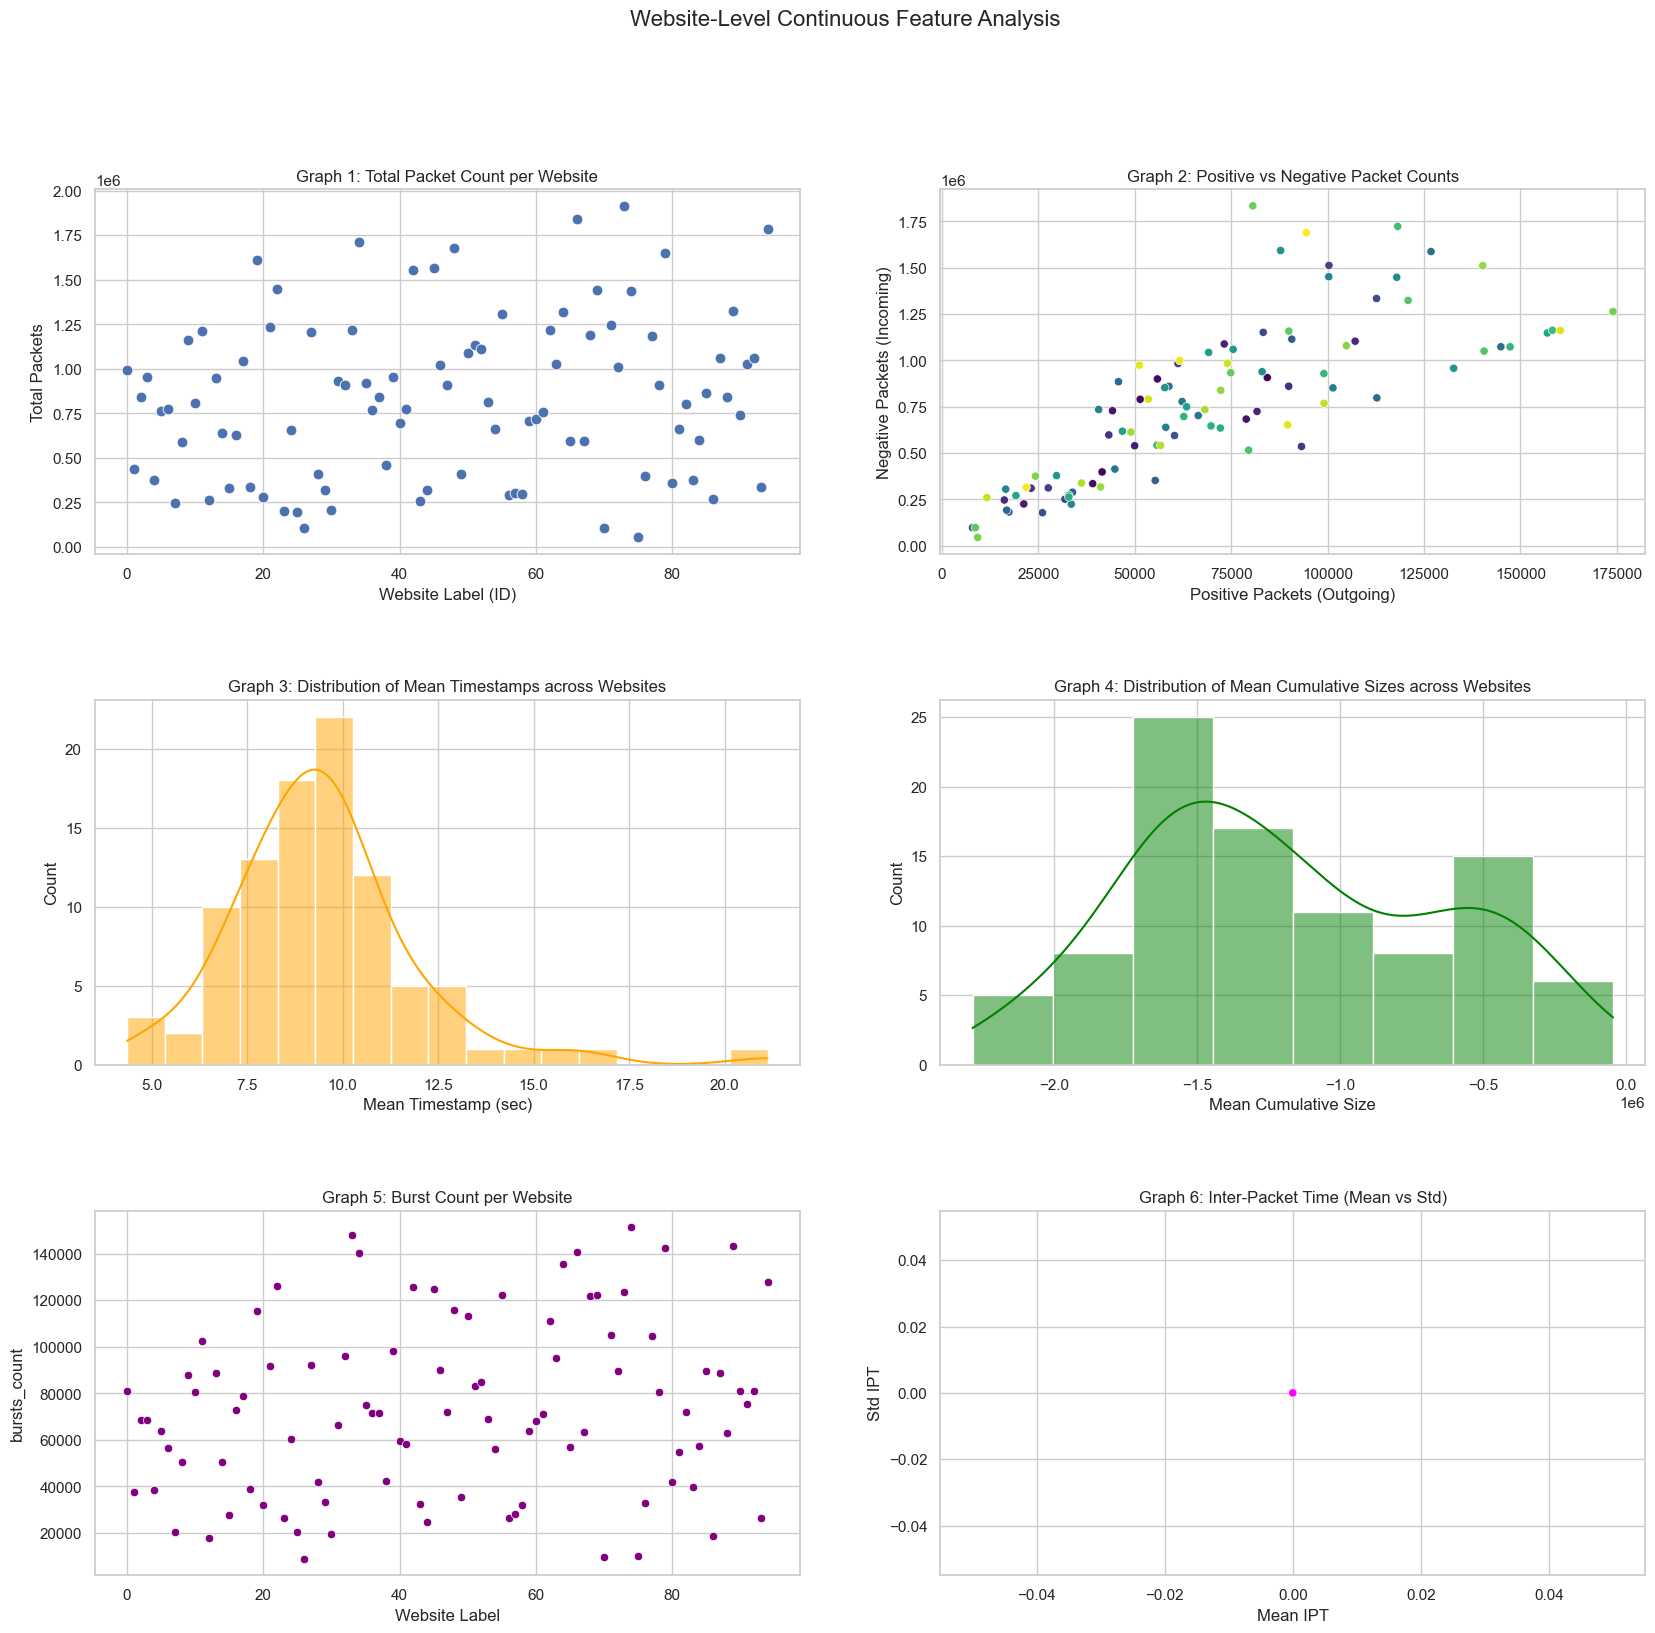


웹사이트별 Feature 상관관계 분석...


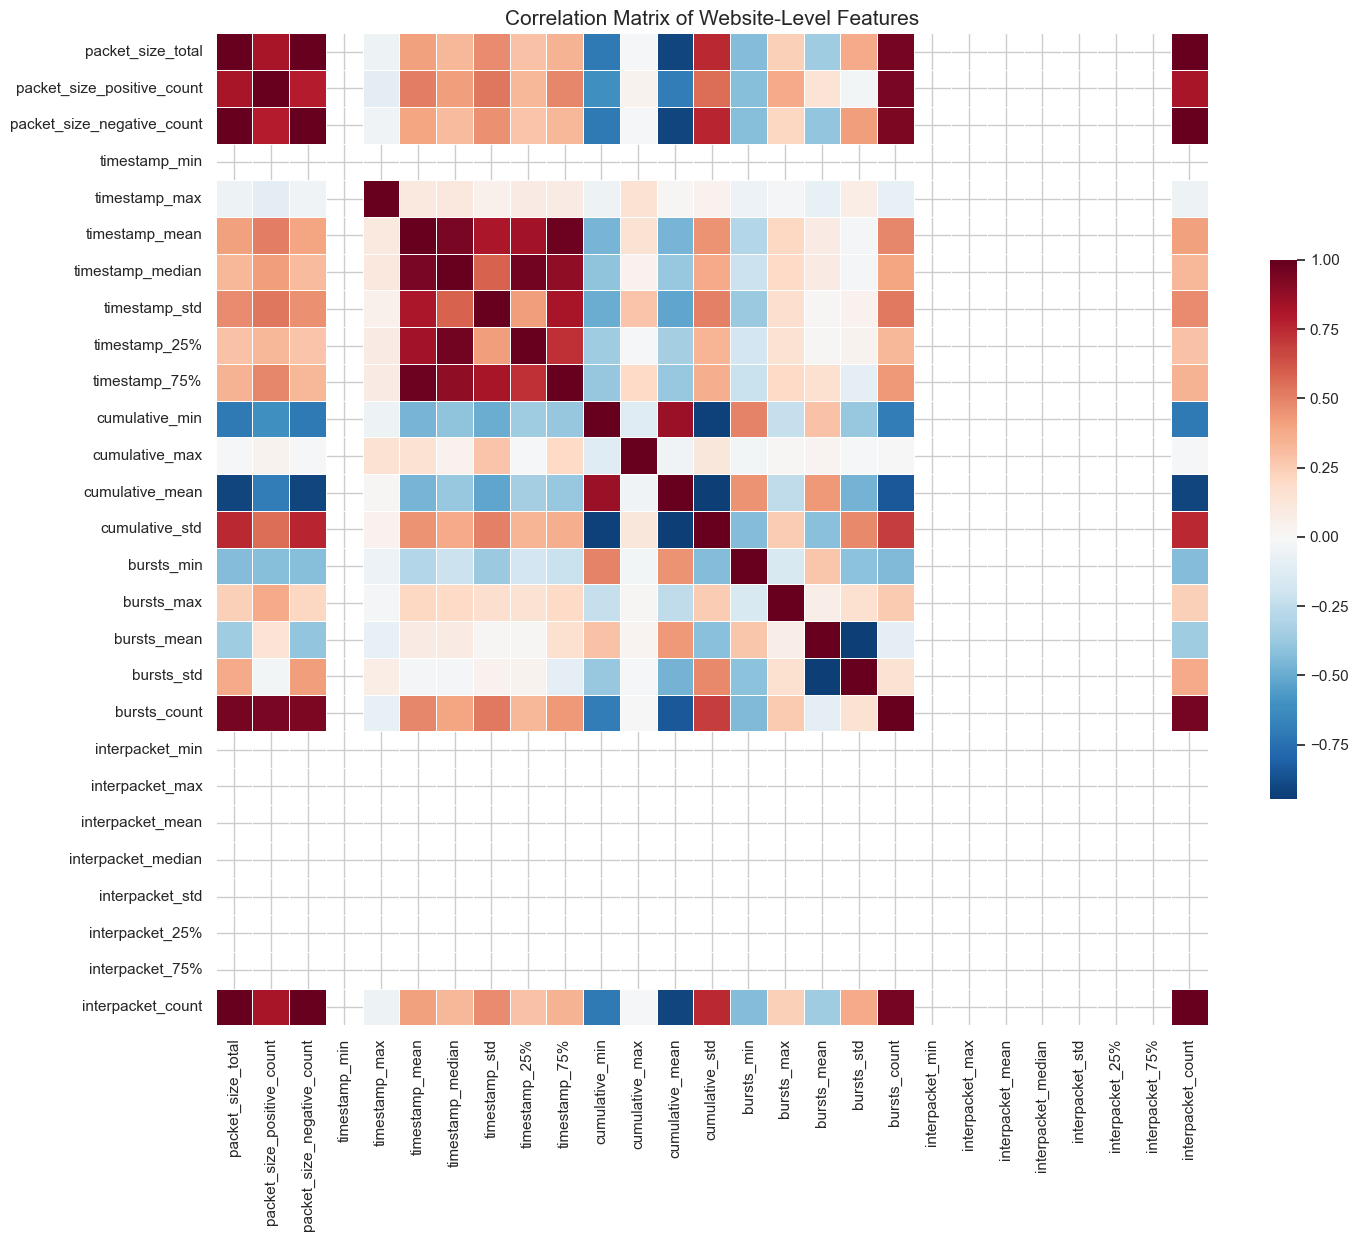


[Extreme Cases Analysis]

Top 5 Heavy Websites (Most Packets):
 label  packet_size_total  timestamp_max
    73            1914554          79.55
    66            1841237          57.13
    94            1783186          66.71
    34            1713954          73.42
    48            1680463          71.62

Top 5 Long Duration Websites:
 label  packet_size_total  timestamp_max
     6             772500          86.02
    24             654759          85.93
    65             597625          85.31
    59             706944          85.11
    80             357806          84.98

Top 5 Bursty Websites:
 label  bursts_count  bursts_mean
    74        151447 -3682.946932
    33        148110 -3209.480521
    89        143252 -3578.038366
    79        142506 -4924.747590
    66        140742 -5838.306803


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# ============================================================
# WEBSITE-LEVEL CONTINUOUS VISUALIZATION
# ============================================================

print("\n" + "=" * 80)
print("WEBSITE-LEVEL VISUALIZATION (95 Websites Comparison)")
print("=" * 80)

# 시각화 스타일 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (20, 16)

# ------------------------------------------------------------
# 1. 웹사이트별 패킷 수 구성 (Positive vs Negative)
# ------------------------------------------------------------

fig, axes = plt.subplots(3, 2, figsize=(20, 18))
plt.subplots_adjust(hspace=0.4)

# Graph 1: Total Packet Counts per Website (Scatter)
sns.scatterplot(data=results_df, x='label', y='packet_size_total', ax=axes[0, 0], color='b', s=60)
axes[0, 0].set_title('Graph 1: Total Packet Count per Website')
axes[0, 0].set_xlabel('Website Label (ID)')
axes[0, 0].set_ylabel('Total Packets')

# Graph 2: Incoming vs Outgoing Packets (Scatter Comparison)
# 양의 상관관계가 있는지 확인
sns.scatterplot(data=results_df, x='packet_size_positive_count', y='packet_size_negative_count',
                hue='label', palette='viridis', ax=axes[0, 1], legend=False)
axes[0, 1].set_title('Graph 2: Positive vs Negative Packet Counts')
axes[0, 1].set_xlabel('Positive Packets (Outgoing)')
axes[0, 1].set_ylabel('Negative Packets (Incoming)')

# Graph 3: Website-Level Mean Timestamp Distribution # 각 웹사이트의 "평균 시간"이 어떻게 분포되어 있는지 확인
sns.histplot(results_df['timestamp_mean'], kde=True, ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Graph 3: Distribution of Mean Timestamps across Websites')
axes[1, 0].set_xlabel('Mean Timestamp (sec)')

# Graph 4: Website-Level Mean Cumulative Size Distribution
sns.histplot(results_df['cumulative_mean'], kde=True, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Graph 4: Distribution of Mean Cumulative Sizes across Websites')
axes[1, 1].set_xlabel('Mean Cumulative Size')

# Graph 5: Burst Count per Website (Bar/Stem plot style via Scatter)
sns.scatterplot(data=results_df, x='label', y='bursts_count', ax=axes[2, 0], color='purple')
axes[2, 0].set_title('Graph 5: Burst Count per Website')
axes[2, 0].set_xlabel('Website Label')

# Graph 6: Inter-Packet Time Mean vs Std
sns.scatterplot(data=results_df, x='interpacket_mean', y='interpacket_std',
                hue='label', palette='cool', ax=axes[2, 1], legend=False)
axes[2, 1].set_title('Graph 6: Inter-Packet Time (Mean vs Std)')
axes[2, 1].set_xlabel('Mean IPT')
axes[2, 1].set_ylabel('Std IPT')

plt.suptitle('Website-Level Continuous Feature Analysis', fontsize=16)
plt.show()


# ------------------------------------------------------------
# 2. 웹사이트 간 유사성 히트맵 (상관관계)
# ------------------------------------------------------------
print("\n웹사이트별 Feature 상관관계 분석...")
plt.figure(figsize=(16, 14))

# Label을 제외한 수치형 데이터만 선택
corr_cols = [col for col in results_df.columns if col != 'label']
corr_matrix_site = results_df[corr_cols].corr()

# 상관관계 히트맵
mask = np.triu(np.ones_like(corr_matrix_site, dtype=bool))
sns.heatmap(corr_matrix_site, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Website-Level Features', fontsize=15)
plt.show()

# ------------------------------------------------------------
# 3. 특이 웹사이트 탐지 (Top 5 Extremes)
# ------------------------------------------------------------
print("\n[Extreme Cases Analysis]")

# 가장 패킷이 많은 웹사이트 Top 5
top_traffic = results_df.nlargest(5, 'packet_size_total')[['label', 'packet_size_total', 'timestamp_max']]
print("\nTop 5 Heavy Websites (Most Packets):")
print(top_traffic.to_string(index=False))

# 가장 전송 시간이 긴 웹사이트 Top 5
longest_duration = results_df.nlargest(5, 'timestamp_max')[['label', 'packet_size_total', 'timestamp_max']]
print("\nTop 5 Long Duration Websites:")
print(longest_duration.to_string(index=False))

# 가장 Burst가 많은 웹사이트 Top 5
most_bursty = results_df.nlargest(5, 'bursts_count')[['label', 'bursts_count', 'bursts_mean']]
print("\nTop 5 Bursty Websites:")
print(most_bursty.to_string(index=False))

## 1-5. Trace별 Continuous Features 통계

In [ ]:
# ============================================================
# Trace-Level Continuous Statistics
# ============================================================

print("\n" + "=" * 80)
print("TRACE-LEVEL CONTINUOUS STATISTICS 분석")
print("=" * 80)

trace_stats_list = []

# 전체 데이터 순회
for site_id, traces in enumerate(mon_data):
    if isinstance(mon_data, dict):
        iterator = mon_data.values()
    else:
        iterator = mon_data

    current_traces = traces if not isinstance(mon_data, dict) else mon_data[site_id]

    for trace_idx, trace in enumerate(current_traces):
        # 1. Feature Extraction
        ps = analyze_packet_sizes(trace)
        ts = analyze_timestamps(trace)
        cs = analyze_cumulative_sizes(trace)
        bs = analyze_bursts(trace)
        ipt = analyze_inter_packet_times(trace)

        # 2. Calculate Statistics per Trace
        stats = {
            'site_id': site_id,
            'trace_id': trace_idx,

            # Packet Sizes Stats
            'packet_size_total': len(ps),
            'packet_size_positive_count': sum(1 for x in ps if x > 0),
            'packet_size_negative_count': sum(1 for x in ps if x < 0),

            # Timestamp Stats
            'timestamp_mean': np.mean(ts),
            'timestamp_std': np.std(ts),
            'timestamp_median': np.median(ts),
            'timestamp_max': np.max(ts),
            'timestamp_25%': np.percentile(ts, 25),
            'timestamp_75%': np.percentile(ts, 75),

            # Cumulative Sizes Stats
            'cumulative_mean': np.mean(cs),
            'cumulative_std': np.std(cs),
            'cumulative_min': np.min(cs),
            'cumulative_max': np.max(cs),

            # Bursts Stats
            'bursts_count': len(bs),
            'bursts_mean': np.mean(bs) if len(bs) > 0 else 0,
            'bursts_std': np.std(bs) if len(bs) > 0 else 0,

            # IPT Stats
            'interpackettimes_mean': np.mean(ipt) if len(ipt) > 0 else 0,
            'interpackettimes_std': np.std(ipt) if len(ipt) > 0 else 0,
            'interpackettimes_max': np.max(ipt) if len(ipt) > 0 else 0
        }
        trace_stats_list.append(stats)

# DataFrame 생성
trace_df = pd.DataFrame(trace_stats_list)

# CSV 저장
csv_filename = "trace_continuous_summary.csv"
trace_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"Trace 단위 통계 완료. 총 {len(trace_df)}개의 Trace 분석됨.")
print(f"파일 저장 완료: {csv_filename}")

# 미리보기
print(trace_df.head())


TRACE-LEVEL CONTINUOUS STATISTICS 분석
Trace 단위 통계 완료. 총 19000개의 Trace 분석됨.
파일 저장 완료: trace_continuous_summary.csv
   site_id  trace_id  packet_size_total  packet_size_positive_count  \
0        0         0               1420                         121   
1        0         1                517                          80   
2        0         2               1357                         118   
3        0         3               1445                         122   
4        0         4               1405                         115   

   packet_size_negative_count  timestamp_mean  timestamp_std  \
0                        1299        4.315749       1.128342   
1                         437        4.611815       1.370610   
2                        1239        5.488969       1.179265   
3                        1323        5.995512       1.708888   
4                        1290        4.698869       1.297085   

   timestamp_median  timestamp_max  timestamp_25%  ...  cumulative_mean  \

## 1-6. Trace별 Continuous Features 시각화


TRACE-LEVEL CONTINUOUS FEATURE VISUALIZATION


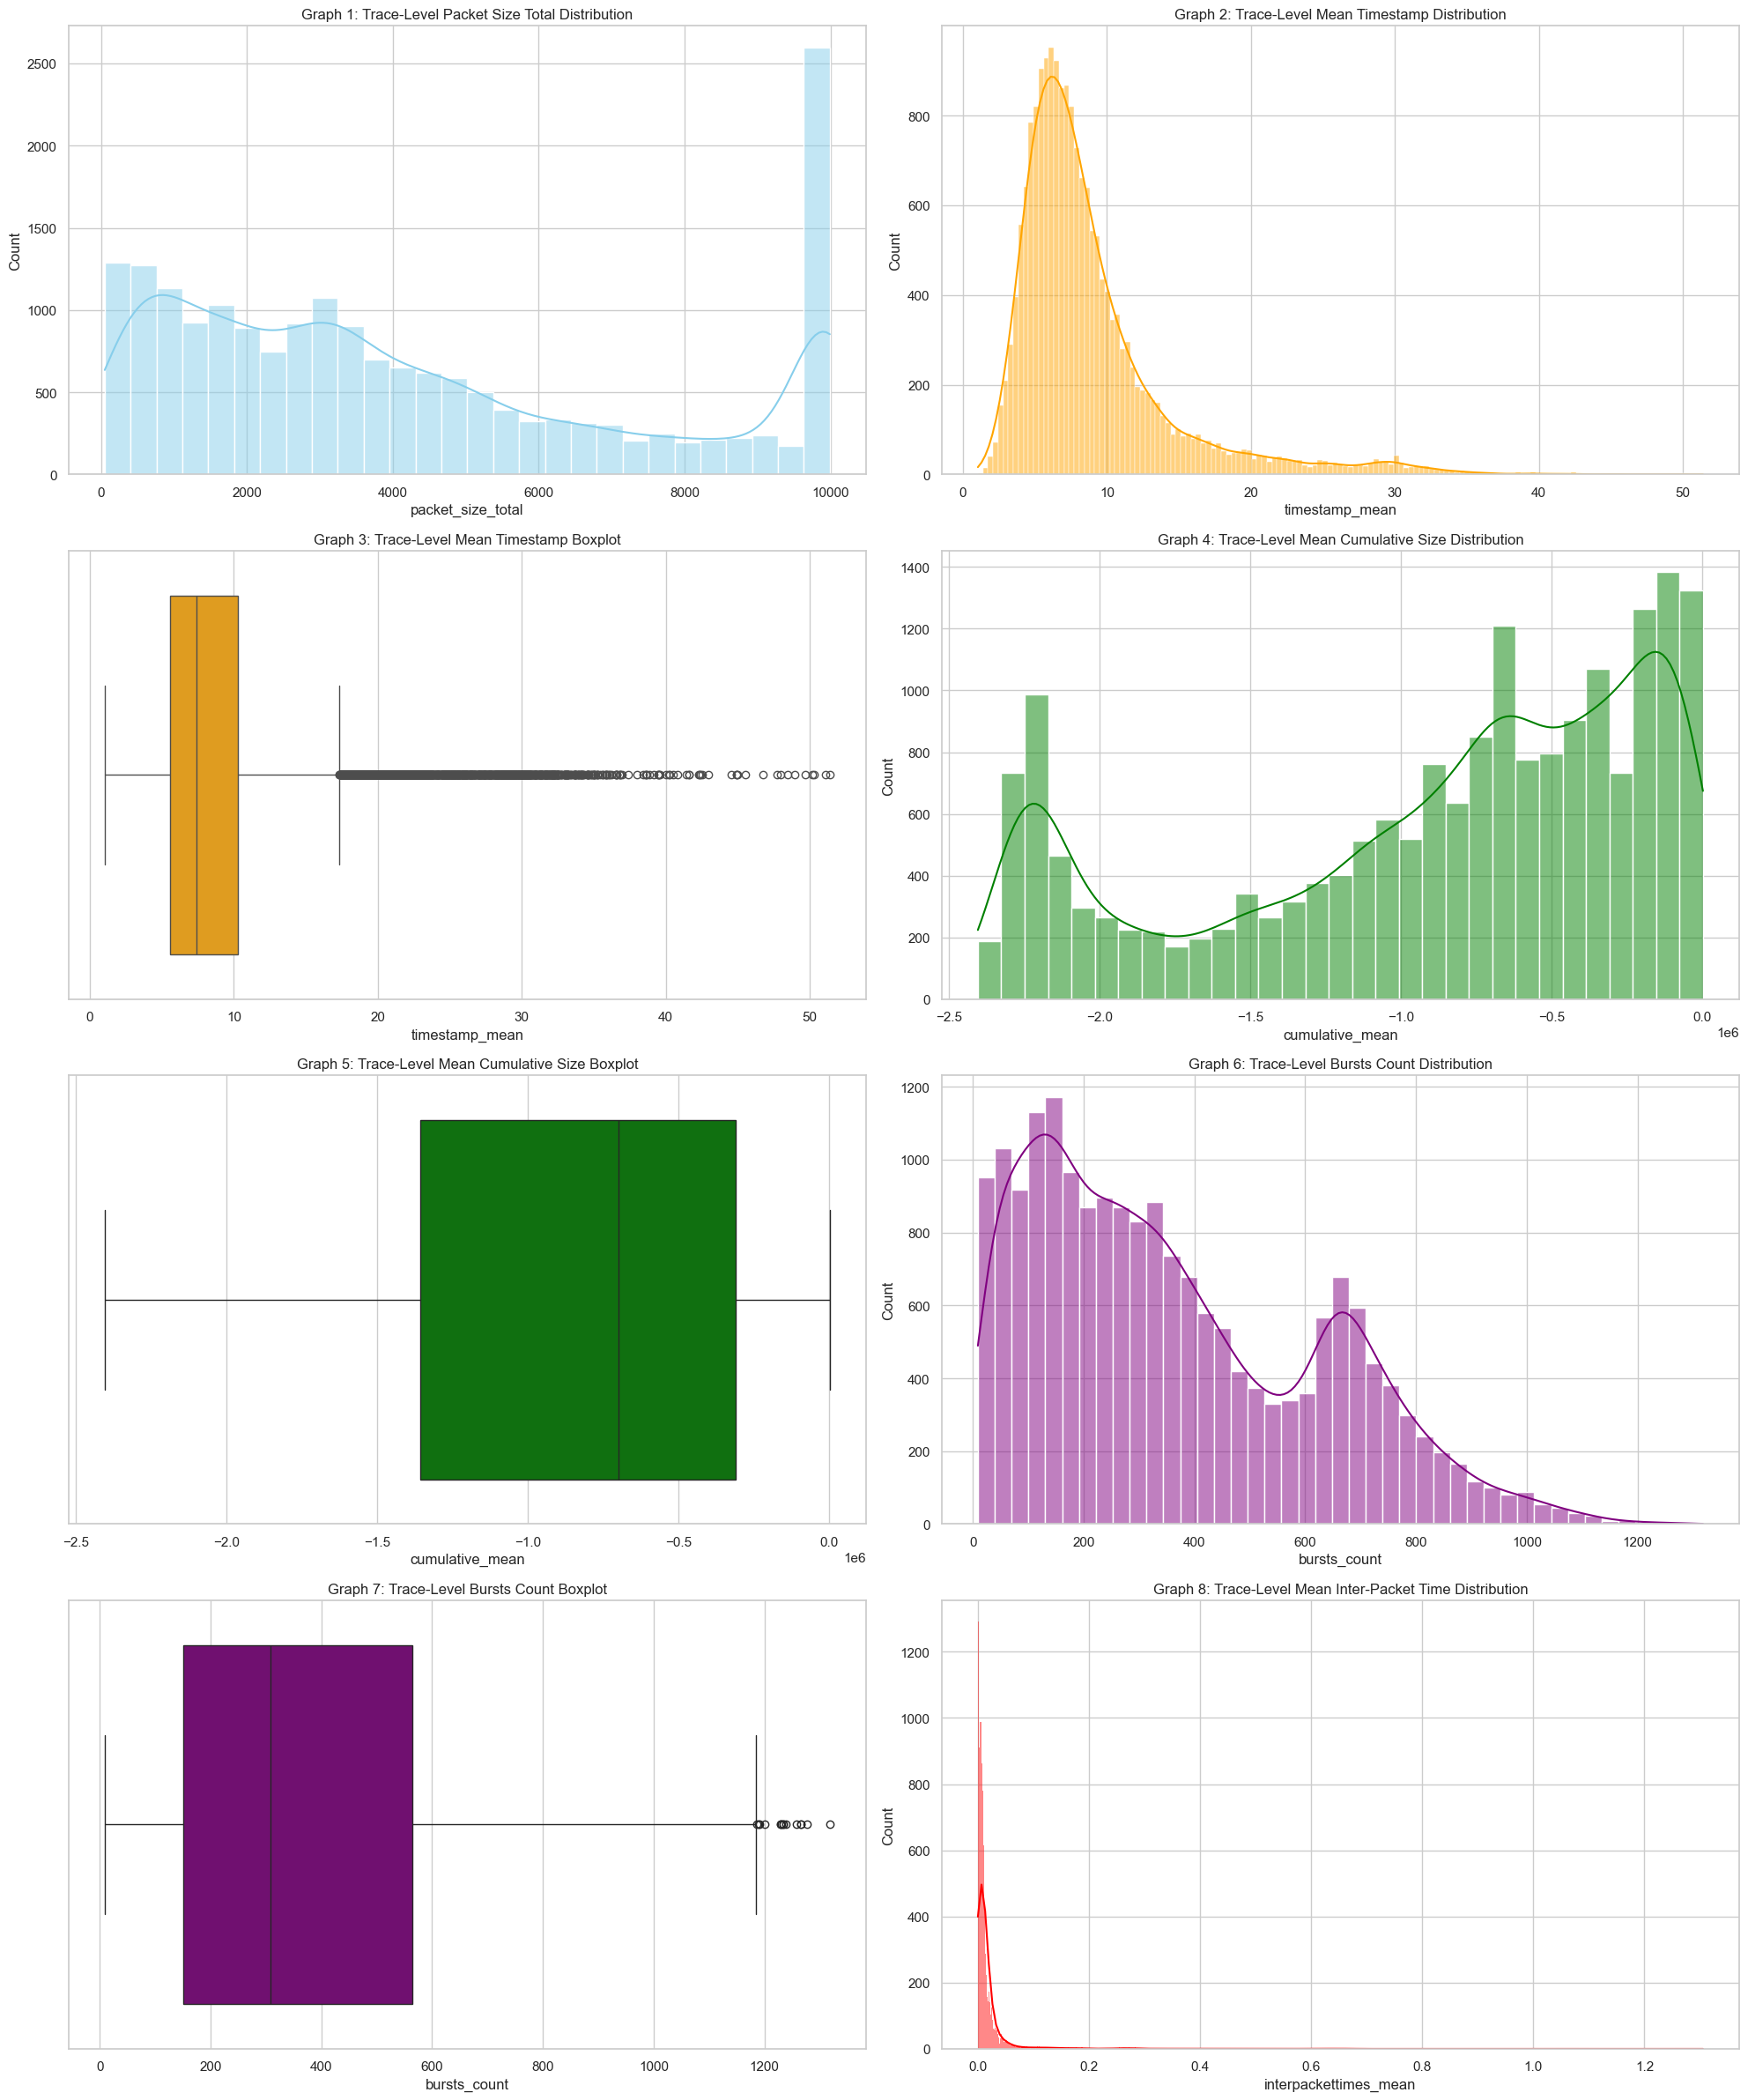

In [ ]:
import seaborn as sns
# ============================================================
# Trace별 Continuous 통계 시각화
# ============================================================

print("\n" + "=" * 80)
print("TRACE-LEVEL CONTINUOUS FEATURE VISUALIZATION")
print("=" * 80)

# 시각화 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)
fig, axes = plt.subplots(4, 2, figsize=(20, 24))

# Graph 1: Trace-Level Packet Size Total Distribution
sns.histplot(data=trace_df, x='packet_size_total', kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Graph 1: Trace-Level Packet Size Total Distribution')

# Graph 2: Trace-Level Mean Timestamp Distribution
sns.histplot(data=trace_df, x='timestamp_mean', kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Graph 2: Trace-Level Mean Timestamp Distribution')

# Graph 3: Trace-Level Mean Timestamp Boxplot
sns.boxplot(x=trace_df['timestamp_mean'], ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Graph 3: Trace-Level Mean Timestamp Boxplot')

# Graph 4: Trace-Level Mean Cumulative Size Distribution
sns.histplot(data=trace_df, x='cumulative_mean', kde=True, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Graph 4: Trace-Level Mean Cumulative Size Distribution')

# Graph 5: Trace-Level Mean Cumulative Size Boxplot
sns.boxplot(x=trace_df['cumulative_mean'], ax=axes[2, 0], color='green')
axes[2, 0].set_title('Graph 5: Trace-Level Mean Cumulative Size Boxplot')

# Graph 6: Trace-Level Bursts Count Distribution
sns.histplot(data=trace_df, x='bursts_count', kde=True, ax=axes[2, 1], color='purple')
axes[2, 1].set_title('Graph 6: Trace-Level Bursts Count Distribution')

# Graph 7: Trace-Level Bursts Count Boxplot
sns.boxplot(x=trace_df['bursts_count'], ax=axes[3, 0], color='purple')
axes[3, 0].set_title('Graph 7: Trace-Level Bursts Count Boxplot')

# Graph 8: Trace-Level Mean Inter-Packet Time Distribution
sns.histplot(data=trace_df, x='interpackettimes_mean', kde=True, ax=axes[3, 1], color='red')
axes[3, 1].set_title('Graph 8: Trace-Level Mean Inter-Packet Time Distribution')

plt.tight_layout()
plt.show()


TRACE-LEVEL CONTINUOUS FEATURE CORRELATION ANALYSIS

상관관계 높은 trace-level feature들 (Top list):
                  Feature1                   Feature2  Correlation
            cumulative_std             cumulative_min    -0.999593
            cumulative_min             cumulative_std    -0.999593
packet_size_negative_count            cumulative_mean    -0.999063
           cumulative_mean packet_size_negative_count    -0.999063
            cumulative_std            cumulative_mean    -0.998573
           cumulative_mean             cumulative_std    -0.998573
           cumulative_mean             cumulative_min     0.998466
            cumulative_min            cumulative_mean     0.998466
packet_size_negative_count             cumulative_min    -0.998057
            cumulative_min packet_size_negative_count    -0.998057
         packet_size_total packet_size_negative_count     0.998020
packet_size_negative_count          packet_size_total     0.998020
packet_size_negative_count        

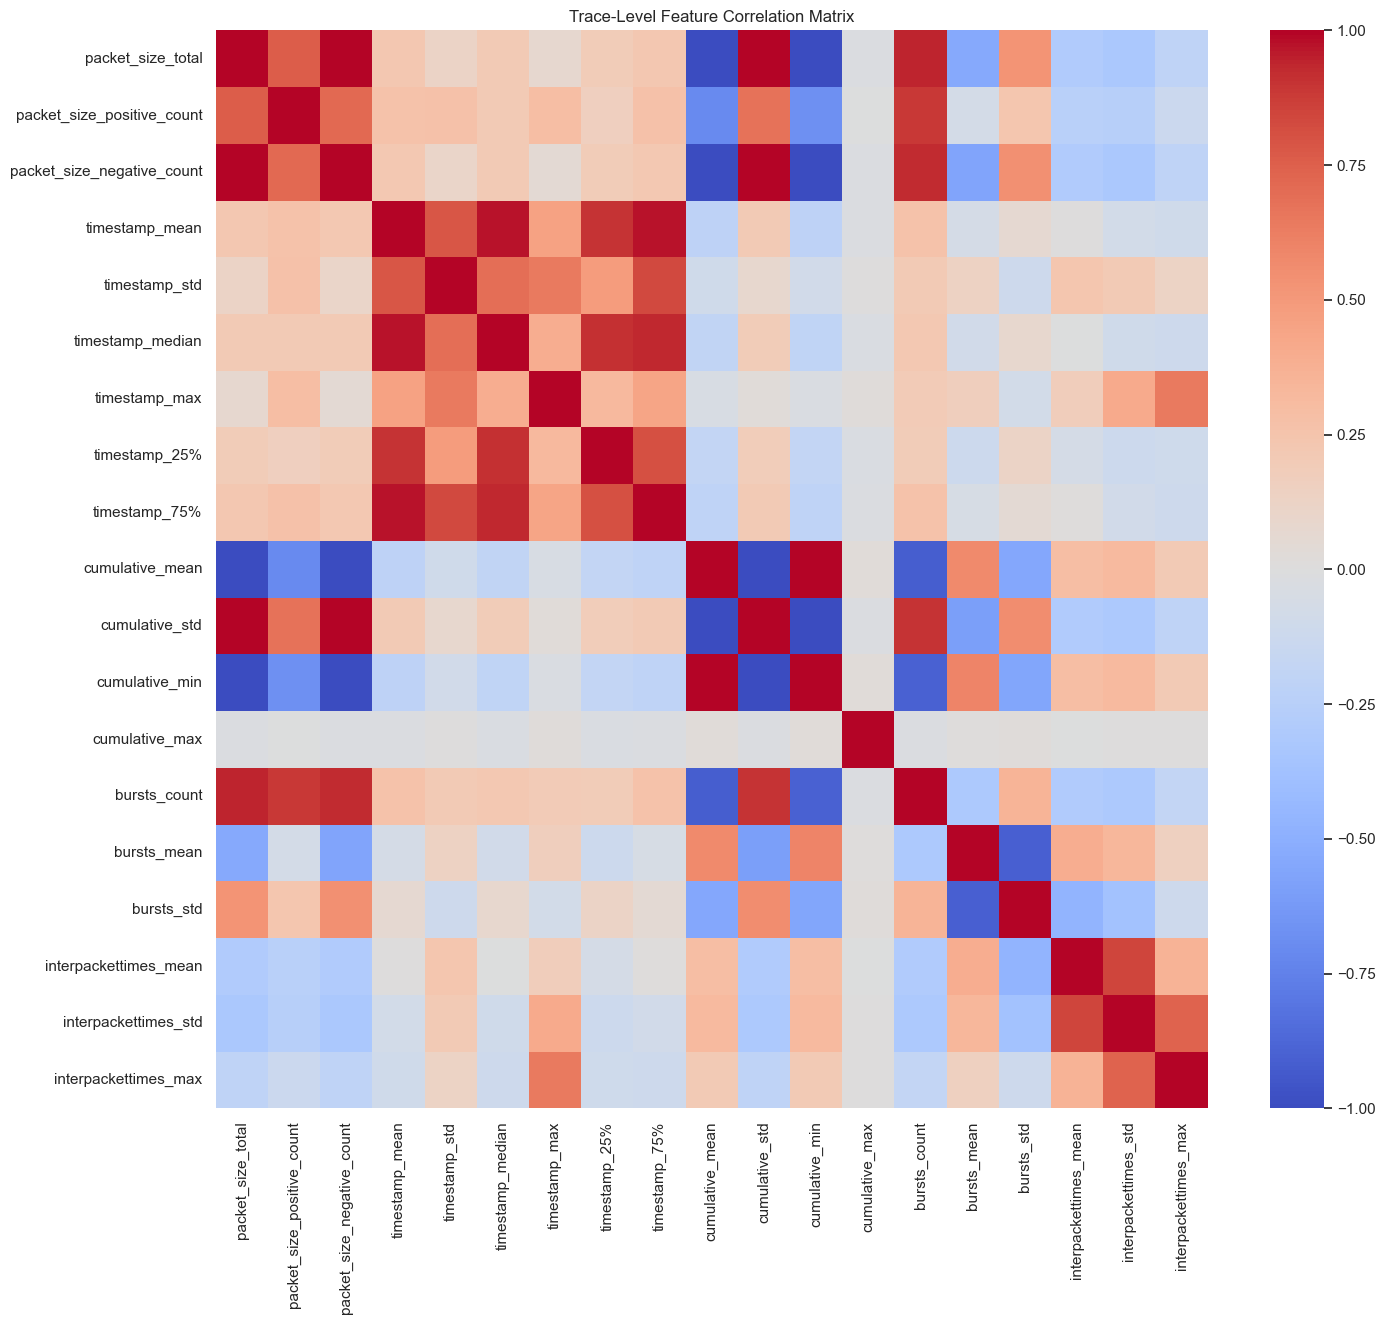

In [ ]:

# ============================================================
# 4. Trace Level Continuous Feature 상관관계 분석
# ============================================================

print("\n" + "=" * 80)
print("TRACE-LEVEL CONTINUOUS FEATURE CORRELATION ANALYSIS")
print("=" * 80)

# 상관관계 계산을 위한 수치형 컬럼 선택 (site_id, trace_id 제외)
numeric_cols = trace_df.columns.drop(['site_id', 'trace_id'])
correlation_matrix = trace_df[numeric_cols].corr()

# 상관관계 매트릭스를 Unstack하여 리스트 형태로 변환 (Feature1, Feature2, Correlation)
corr_unstacked = correlation_matrix.unstack()
corr_df = pd.DataFrame(corr_unstacked, columns=['Correlation']).reset_index()
corr_df.columns = ['Feature1', 'Feature2', 'Correlation']

# 자기 자신과의 상관관계(1.0) 제외 및 중복 제거
# (Feature1 < Feature2 조건을 사용하여 대칭 제거)
corr_df = corr_df[corr_df['Feature1'] != corr_df['Feature2']]

# 상관계수 절대값을 기준으로 내림차순 정렬
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_sorted = corr_df.sort_values(by='Abs_Correlation', ascending=False)

# 상위 상관관계 출력 (threshold 0.8 이상만 보기 좋게 출력)
high_corr = corr_sorted[corr_sorted['Abs_Correlation'] >= 0.8]

print("\n상관관계 높은 trace-level feature들 (Top list):")
print(high_corr[['Feature1', 'Feature2', 'Correlation']].head(30).to_string(index=False))

# (옵션) 상관관계 히트맵 시각화
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Trace-Level Feature Correlation Matrix')
plt.show()

## 2. Categorical Features 분석 및 시각화
다음과 같은 세션 단위 범주형(Categorical) 정보를 분석
- 총 패킷 수  
- 수신/송신 비율  
- 초당 패킷 수  

## 2-1. 전체 데이터에서 Categorical Features 통계

In [ ]:
# ============================================================
# CATEGORICAL FEATURES ANALYSIS FUNCTIONS
# ============================================================

def extract_categorical(trace):
    cat = {}

    # 기본 계산
    incoming = sum(1 for ts in trace if ts < 0)
    outgoing = sum(1 for ts in trace if ts > 0)
    total = incoming + outgoing

    cat['num_incoming'] = incoming
    cat['num_outgoing'] = outgoing
    cat['total_packets'] = total
    cat['incoming_ratio'] = incoming / total if total > 0 else 0
    cat['outgoing_ratio'] = outgoing / total if total > 0 else 0

    # Outgoing packet ordering list
    outgoing_ts = sorted([ts for ts in trace if ts > 0])
    cat['outgoing_std'] = np.std(outgoing_ts) if len(outgoing_ts) > 0 else 0
    cat['outgoing_avg'] = np.mean(outgoing_ts) if len(outgoing_ts) > 0 else 0

    # Cumulative sizes
    cumulative = analyze_cumulative_sizes(trace)
    cat['sum_cumulative'] = sum(cumulative) if len(cumulative) > 0 else 0

    # Bursts
    bursts = analyze_bursts(trace)
    cat['sum_bursts'] = sum(bursts) if len(bursts) > 0 else 0

    # Packets per second
    duration = max(trace) - min(trace) if len(trace) > 0 else 1
    cat['packets_per_second'] = total / duration if duration > 0 else 0

    # First 30 packets
    first_30 = trace[:30]
    incoming_30 = sum(1 for ts in first_30 if ts < 0)
    outgoing_30 = sum(1 for ts in first_30 if ts > 0)
    cat['incoming_first30'] = incoming_30
    cat['outgoing_first30'] = outgoing_30

    return cat

# 전체 데이터에서 categorical features 통계
print("\nContinuous Features Summary:")

all_categorical = []
for website_id in mon_data.keys():
    for observation in mon_data[website_id]:
        cat = extract_categorical(observation)
        all_categorical.append(cat)

cat_df = pd.DataFrame(all_categorical)

print("\n  Feature 통계:")
print(cat_df.describe().round(4))

# CSV 파일로 저장
csv_filename = 'categorical_features_summary.csv'
cat_df.to_csv(csv_filename, index=False)
print(f"\n'{csv_filename}' 파일로 저장 완료!")



Continuous Features Summary:

  Feature 통계:
       num_incoming  num_outgoing  total_packets  incoming_ratio  \
count    19000.0000    19000.0000     19000.0000      19000.0000   
mean      3839.8458      347.9627      4187.8085          0.9020   
std       2991.5537      289.8524      3206.1233          0.0471   
min         24.0000        6.0000        49.0000          0.4853   
25%       1373.7500      137.0000      1528.7500          0.8804   
50%       3006.5000      281.0000      3308.0000          0.9101   
75%       5772.2500      486.0000      6377.0000          0.9351   
max       9697.0000     4241.0000      9992.0000          0.9705   

       outgoing_ratio  outgoing_std  outgoing_avg  sum_cumulative  \
count      19000.0000    19000.0000    19000.0000    1.900000e+04   
mean           0.0980        4.3980        9.0283   -6.049111e+09   
std            0.0471        3.5799        5.3076    7.617279e+09   
min            0.0295        0.4377        0.7227   -2.402392e+10 

## 2-2. 전체 데이터에서 Categorical Features 시각화


CATEGORICAL FEATURES 시각화 시작...


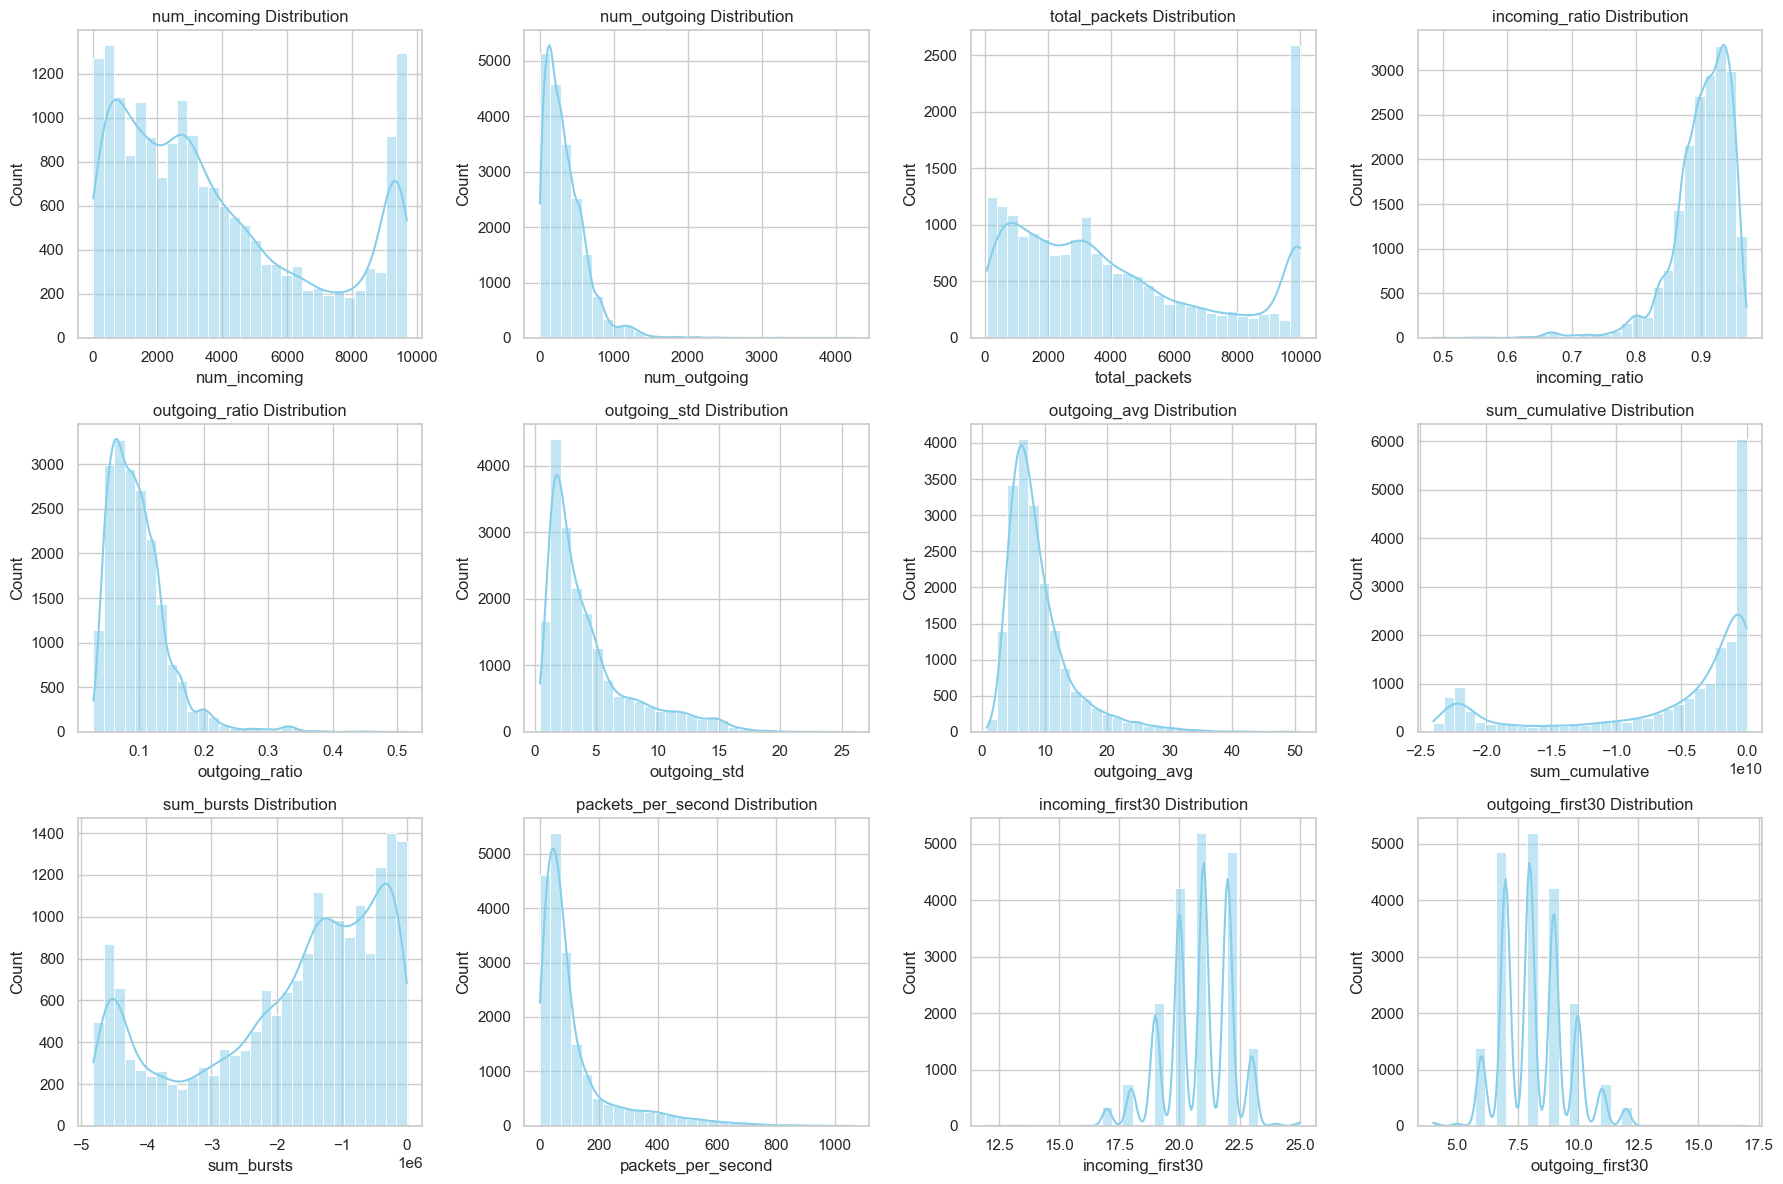

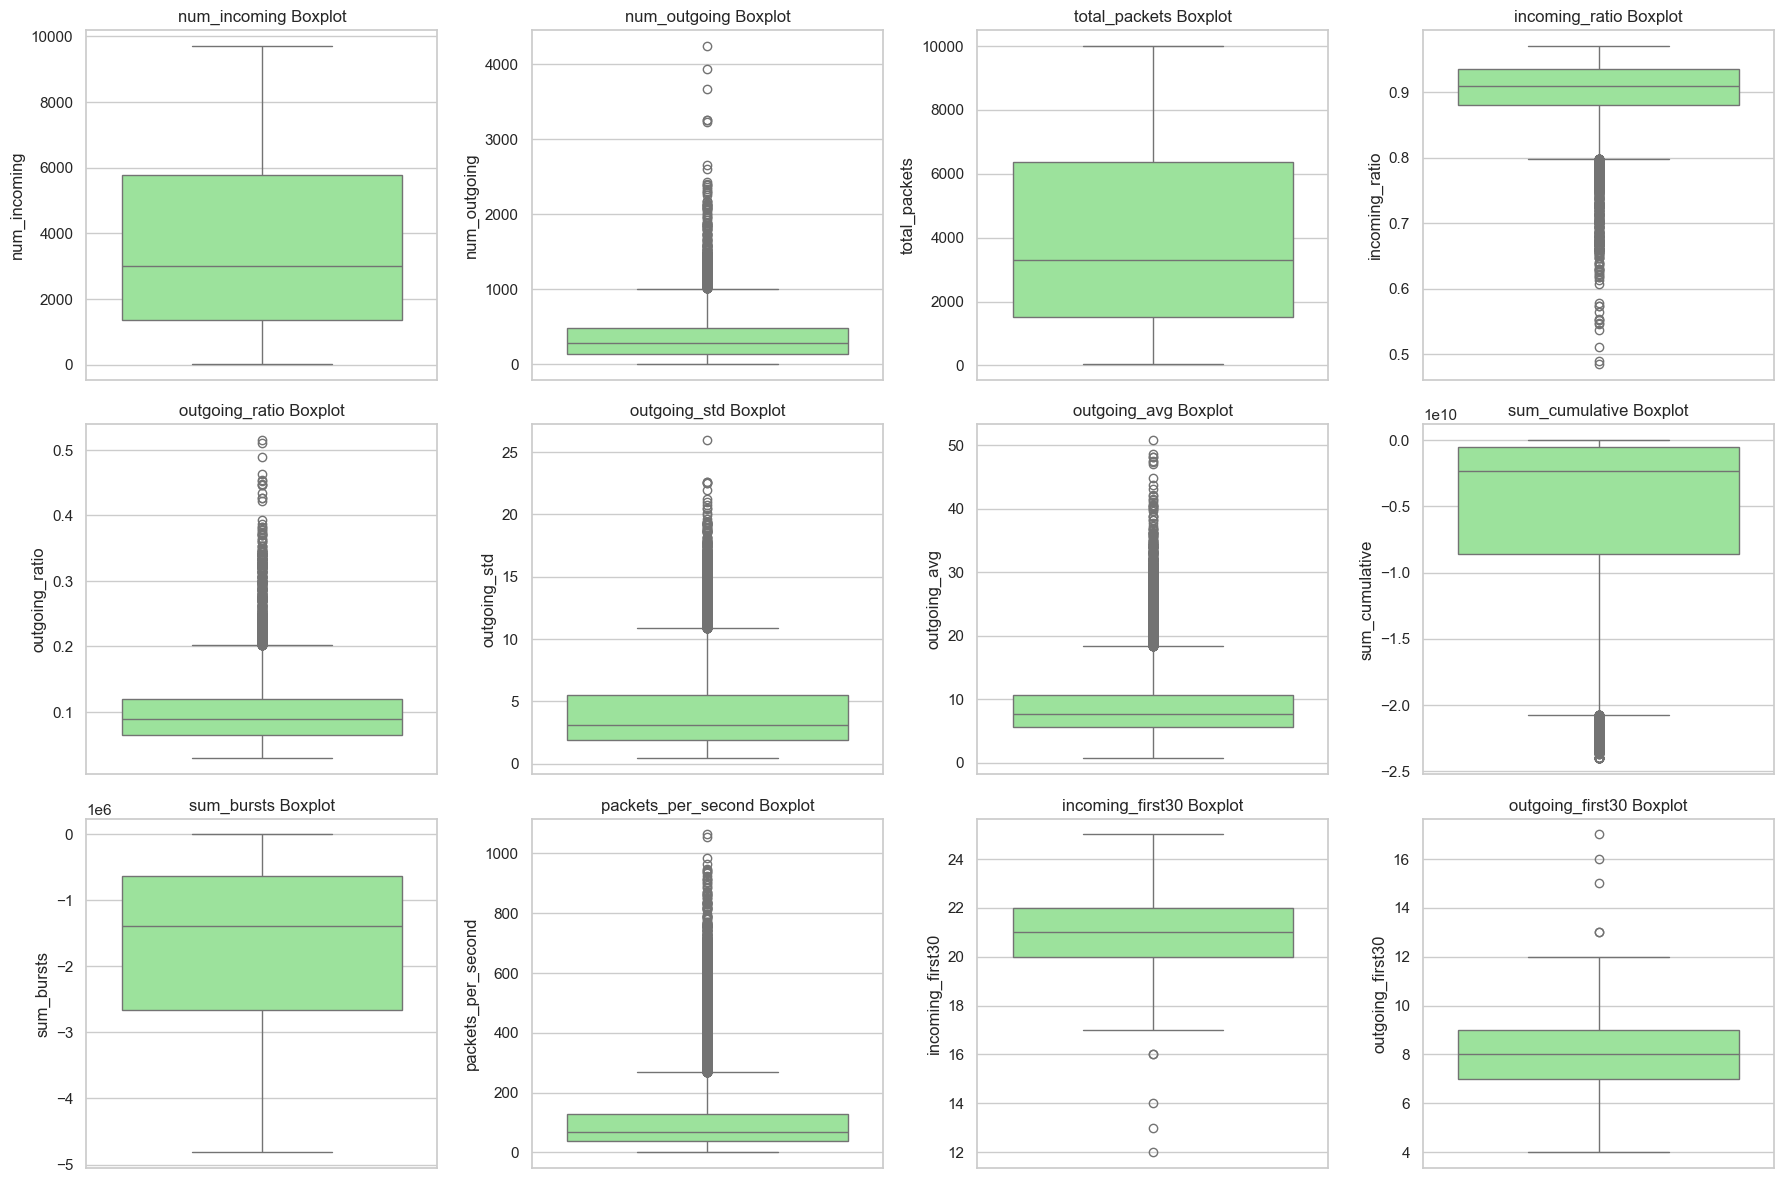

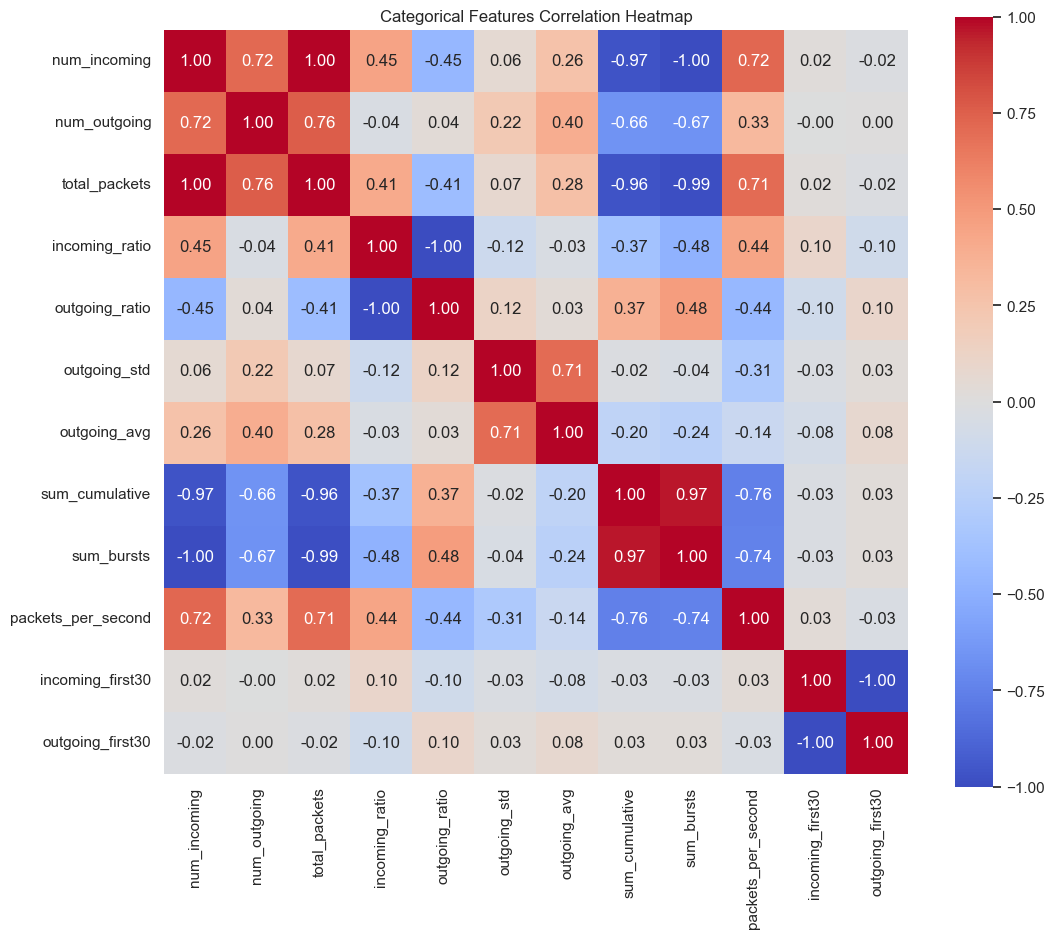

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# CATEGORICAL FEATURES 시각화
# ============================================================

print("\nCATEGORICAL FEATURES 시각화 시작...")

# 1. 각 feature별 히스토그램
cat_features = ['num_incoming','num_outgoing','total_packets','incoming_ratio','outgoing_ratio',
                'outgoing_std','outgoing_avg','sum_cumulative','sum_bursts',
                'packets_per_second','incoming_first30','outgoing_first30']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(cat_features):
    plt.subplot(3, 4, i+1)
    sns.histplot(cat_df[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()

# 2. 각 feature별 박스플롯 (outlier 확인)
plt.figure(figsize=(18, 12))
for i, feature in enumerate(cat_features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=cat_df[feature], color='lightgreen')
    plt.title(f'{feature} Boxplot')
plt.tight_layout()
plt.show()

# 3. feature 간 상관관계 히트맵
plt.figure(figsize=(12, 10))
corr = cat_df[cat_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Categorical Features Correlation Heatmap')
plt.show()


## 2-3. 웹사이트별 Categorical Features 통계

In [ ]:
# ============================================================
# 웹사이트별 통계
# ============================================================

print("\n" + "=" * 80)
print("웹사이트별 Categorical Features 통계")
print("=" * 80)

website_summary = []

for label in sorted(set(y)):
    # 해당 웹사이트 observation만 선택
    cats = [extract_categorical(X2[i]) for i in range(len(y)) if y[i] == label]
    cat_df_site = pd.DataFrame(cats)

    # feature별 평균 계산
    mean_values = cat_df_site.mean().to_dict()
    mean_values['label'] = label  # 웹사이트 라벨 추가
    website_summary.append(mean_values)

website_summary_df = pd.DataFrame(website_summary)

# 컬럼 순서 정리
cols = ['label','num_incoming','num_outgoing','total_packets','incoming_ratio','outgoing_ratio',
        'outgoing_std','outgoing_avg','sum_cumulative','sum_bursts','packets_per_second',
        'incoming_first30','outgoing_first30']
website_summary_df = website_summary_df[cols]

# CSV 저장
csv_filename = "website_categorical_summary.csv"
website_summary_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"'{csv_filename}' 파일로 저장 완료!")

print("웹사이트별 Categorical Features 통계:")
print(website_summary_df.round(4))


웹사이트별 Categorical Features 통계
'website_categorical_summary.csv' 파일로 저장 완료!
웹사이트별 Categorical Features 통계:
    label  num_incoming  num_outgoing  total_packets  incoming_ratio  \
0       0      4537.010       421.815       4958.825          0.8991   
1       1      1989.490       207.690       2197.180          0.8949   
2       2      3950.265       257.065       4207.330          0.9322   
3       3      4498.870       279.360       4778.230          0.9316   
4       4      1674.045       195.545       1869.590          0.8831   
..    ...           ...           ...            ...             ...   
90     90      3259.210       448.230       3707.440          0.8794   
91     91      4872.310       255.975       5128.285          0.9370   
92     92      4995.250       308.300       5303.550          0.9175   
93     93      1577.320       109.230       1686.550          0.9298   
94     94      8443.455       472.475       8915.930          0.9452   

    outgoing_ratio  outgoing

## 2-4. 웹사이트별 Categorical Features 시각화


WEBSITE-LEVEL VISUALIZATION (Categorical Features)


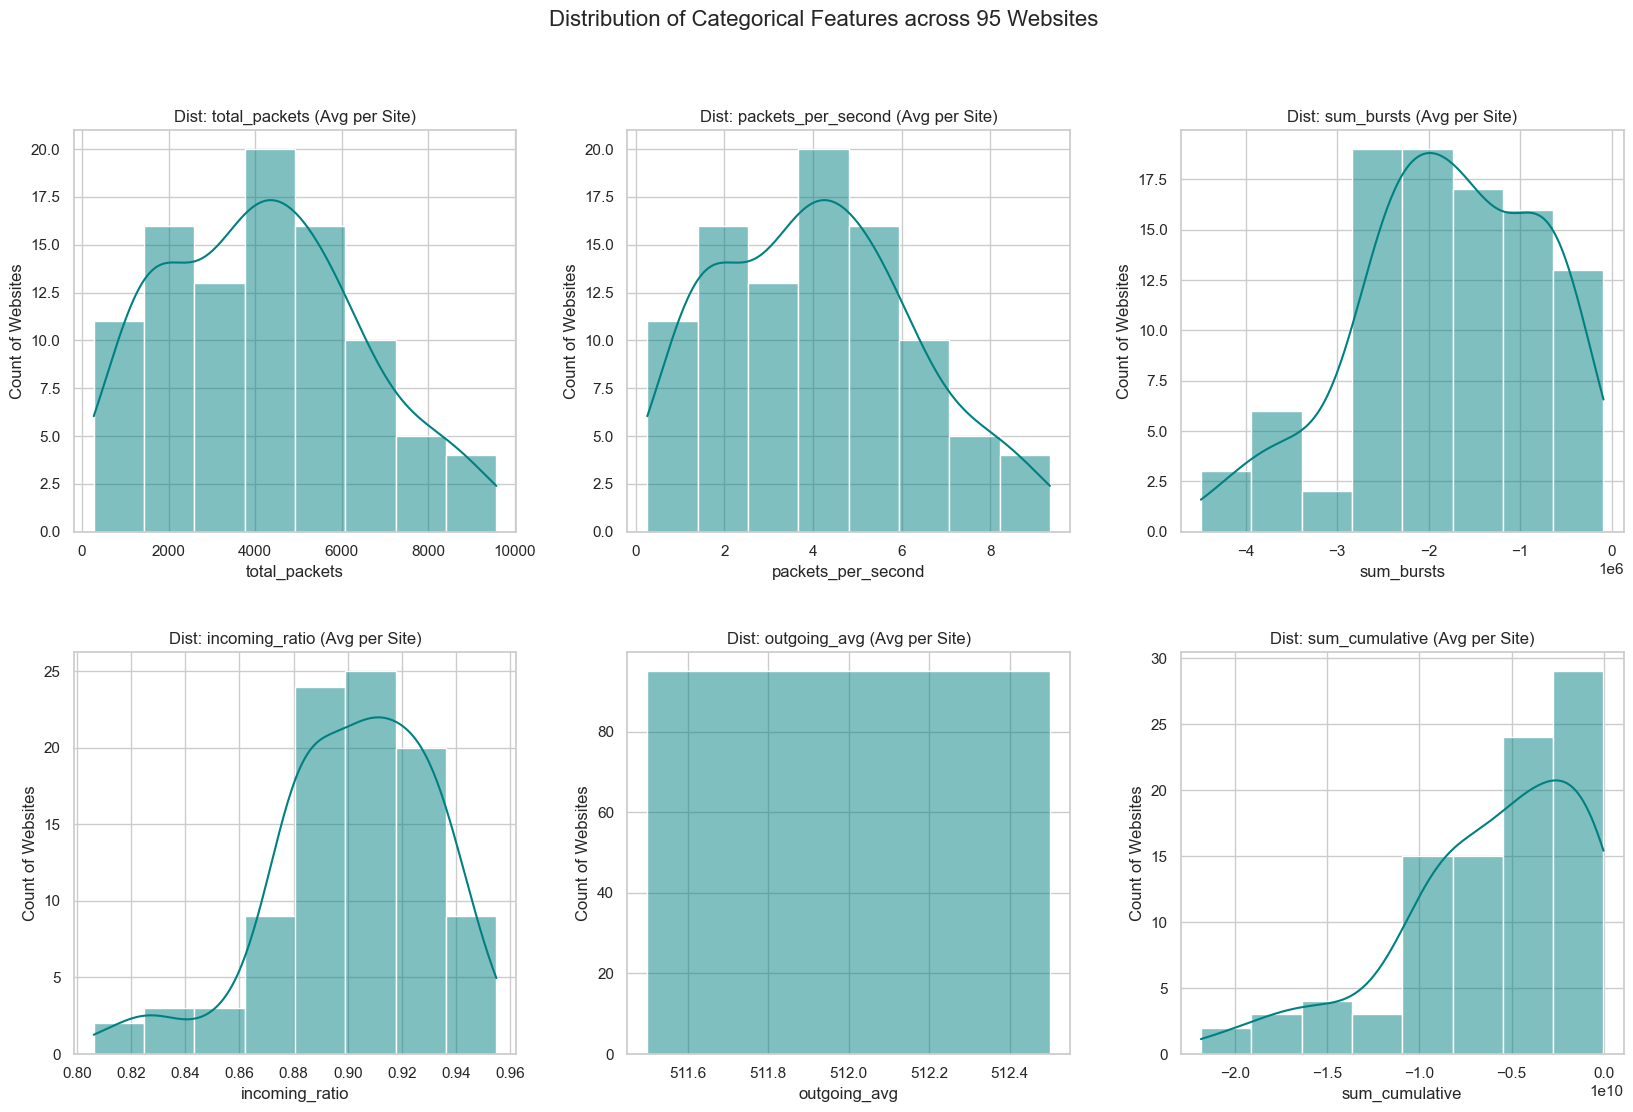

C:\Users\Hwang Jieun\AppData\Local\Temp\ipykernel_15016\2765749306.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_packets, x='label', y='total_packets',
C:\Users\Hwang Jieun\AppData\Local\Temp\ipykernel_15016\2765749306.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_speed, x='label', y='packets_per_second',


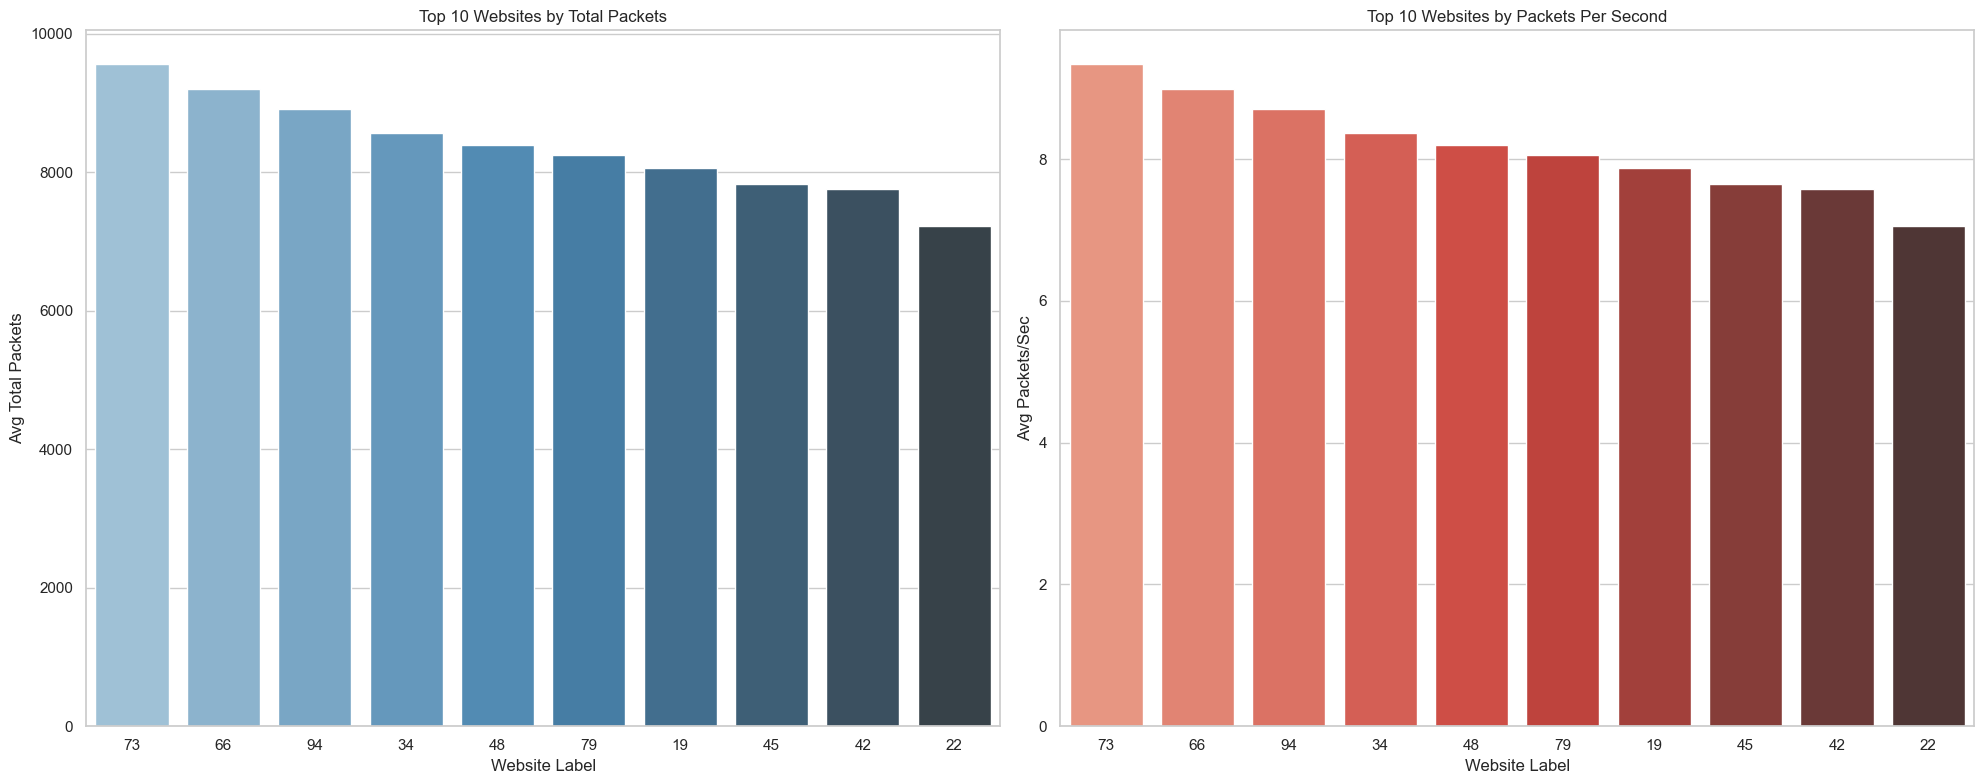

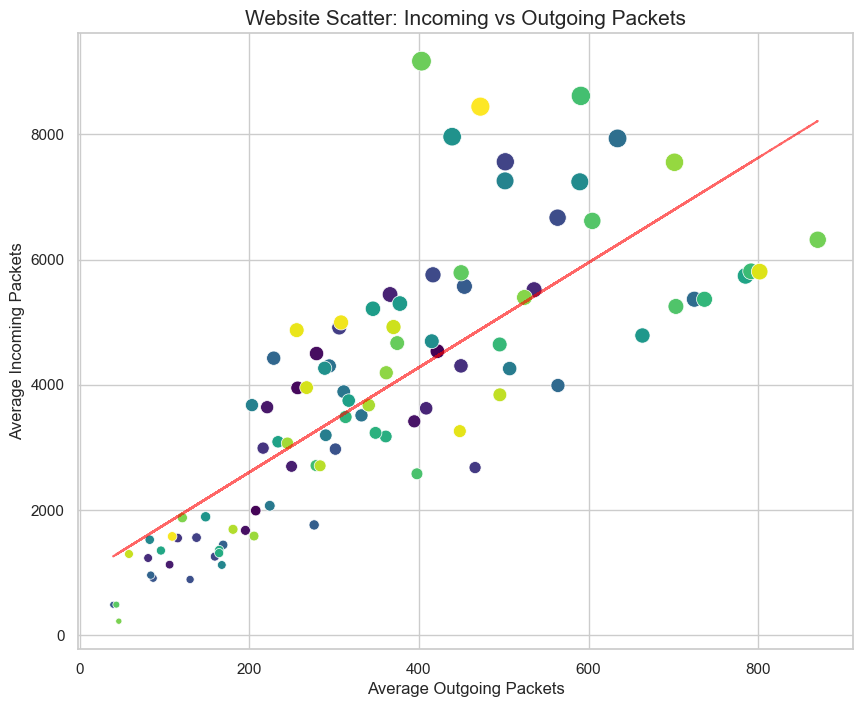


웹사이트별 Feature 상관관계 분석...


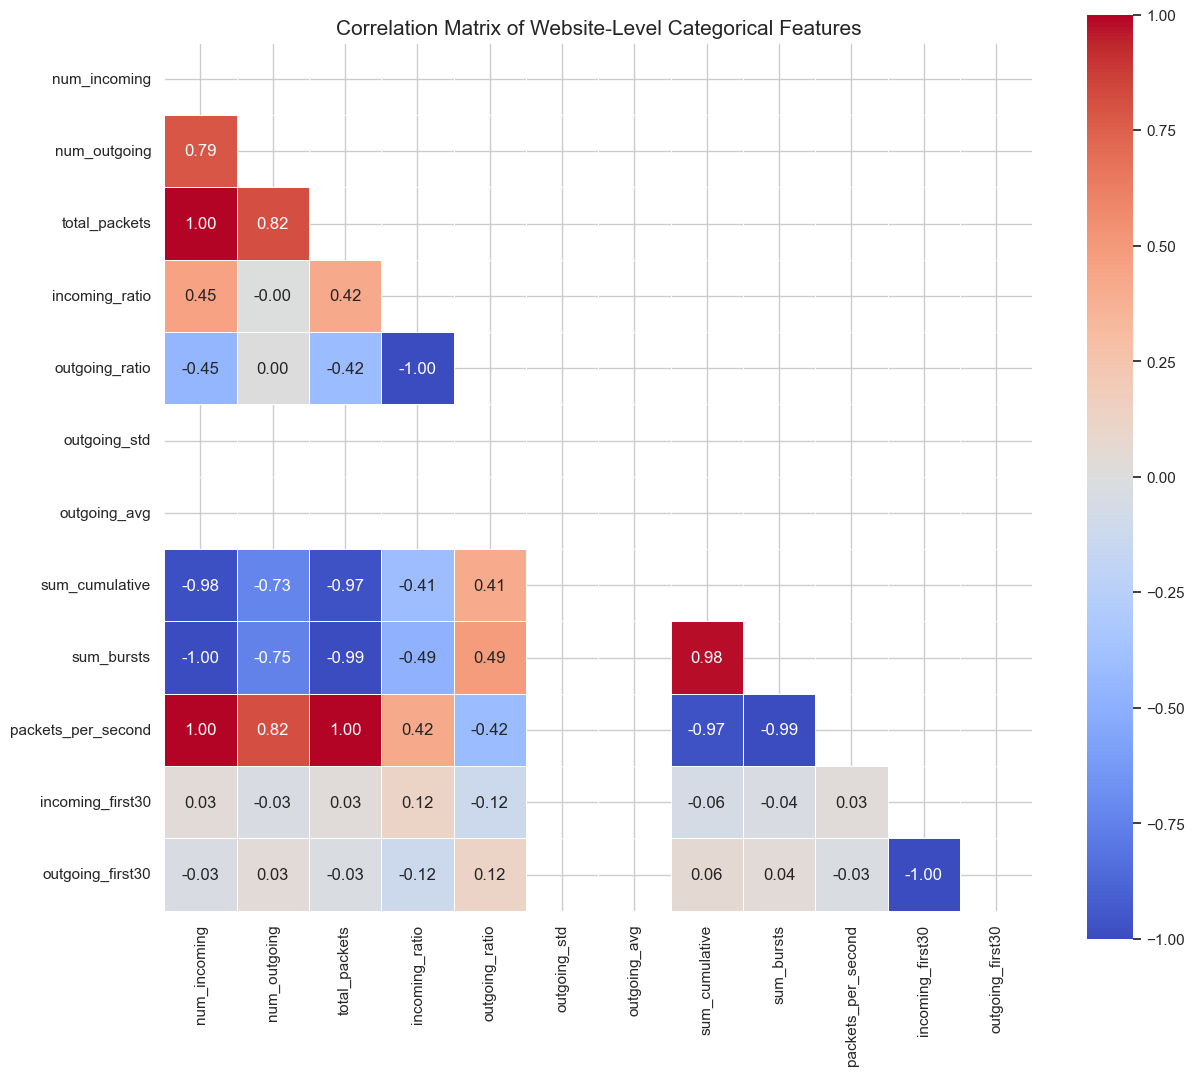


[Summary Insight]
- 가장 트래픽이 많은 웹사이트 Label: 73.0 (Avg 9572.77 packets)
- 가장 속도가 빠른 웹사이트 Label: 73.0 (Avg 9.35 pkts/sec)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# WEBSITE-LEVEL CATEGORICAL VISUALIZATION
# ============================================================

print("\n" + "=" * 80)
print("WEBSITE-LEVEL VISUALIZATION (Categorical Features)")
print("=" * 80)

# 시각화 스타일 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (18, 14)

# ------------------------------------------------------------
# 1. 웹사이트 간 분포 비교
# ------------------------------------------------------------

viz_cols = ['total_packets', 'packets_per_second', 'sum_bursts',
            'incoming_ratio', 'outgoing_avg', 'sum_cumulative']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

for i, col in enumerate(viz_cols):
    row = i // 3
    col_idx = i % 3

    # 히스토그램과 KDE(밀도 그래프) 그리기
    sns.histplot(website_summary_df[col], kde=True, ax=axes[row, col_idx], color='teal')
    axes[row, col_idx].set_title(f'Dist: {col} (Avg per Site)')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Count of Websites')

plt.suptitle('Distribution of Categorical Features across 95 Websites', fontsize=16)
plt.show()

# ------------------------------------------------------------
# 2. 웹사이트 식별을 위한 Top 10 분석
# ------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# (1) 가장 패킷이 많은 웹사이트 Top 10
top_packets = website_summary_df.nlargest(10, 'total_packets')
sns.barplot(data=top_packets, x='label', y='total_packets',
            palette='Blues_d', order=top_packets['label'], ax=axes[0])
axes[0].set_title('Top 10 Websites by Total Packets')
axes[0].set_xlabel('Website Label')
axes[0].set_ylabel('Avg Total Packets')

# (2) 가장 전송 속도가 빠른 웹사이트 Top 10
top_speed = website_summary_df.nlargest(10, 'packets_per_second')
sns.barplot(data=top_speed, x='label', y='packets_per_second',
            palette='Reds_d', order=top_speed['label'], ax=axes[1])
axes[1].set_title('Top 10 Websites by Packets Per Second')
axes[1].set_xlabel('Website Label')
axes[1].set_ylabel('Avg Packets/Sec')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. 주요 Feature 간 관계
# ------------------------------------------------------------

plt.figure(figsize=(10, 8))
sns.scatterplot(data=website_summary_df, x='num_outgoing', y='num_incoming',
                size='total_packets', sizes=(20, 200), hue='label', palette='viridis', legend=False)

m, b = np.polyfit(website_summary_df['num_outgoing'], website_summary_df['num_incoming'], 1)
plt.plot(website_summary_df['num_outgoing'], m*website_summary_df['num_outgoing'] + b, color='red', linestyle='--', alpha=0.6)

plt.title('Website Scatter: Incoming vs Outgoing Packets', fontsize=15)
plt.xlabel('Average Outgoing Packets')
plt.ylabel('Average Incoming Packets')
plt.show()

# ------------------------------------------------------------
# 4. 웹사이트 레벨 상관관계 히트맵
# ------------------------------------------------------------
print("\n웹사이트별 Feature 상관관계 분석...")

plt.figure(figsize=(14, 12))
# Label 제외하고 상관계수 계산
numeric_cols = website_summary_df.drop('label', axis=1)
corr_matrix = numeric_cols.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            mask=mask, vmin=-1, vmax=1, square=True, linewidths=.5)
plt.title('Correlation Matrix of Website-Level Categorical Features', fontsize=15)
plt.show()

# 요약 텍스트 출력
print("\n[Summary Insight]")
print(f"- 가장 트래픽이 많은 웹사이트 Label: {top_packets.iloc[0]['label']} (Avg {top_packets.iloc[0]['total_packets']:.2f} packets)")
print(f"- 가장 속도가 빠른 웹사이트 Label: {top_speed.iloc[0]['label']} (Avg {top_speed.iloc[0]['packets_per_second']:.2f} pkts/sec)")

## 2-5. Trace별 Categorical Features 통계

In [ ]:
# ============================================================
# Trace 단위 통계 (Categorical)
# ============================================================

print("\n" + "=" * 80)
print("TRACE-LEVEL CATEGORICAL STATISTICS")
print("=" * 80)

trace_cat_list = []

print("전체 Trace 데이터 분석 중...")
for i in range(len(y)):
    cat_data = extract_categorical(X2[i])

    cat_data['label'] = y[i]
    cat_data['trace_id'] = i

    trace_cat_list.append(cat_data)

# DataFrame 생성
trace_cat_df = pd.DataFrame(trace_cat_list)

# 컬럼 순서 재정렬
cols = ['trace_id', 'label'] + [c for c in trace_cat_df.columns if c not in ['trace_id', 'label']]
trace_cat_df = trace_cat_df[cols]

# 1. CSV 저장
csv_filename_trace = "trace_categorical_summary.csv"
trace_cat_df.to_csv(csv_filename_trace, index=False, encoding='utf-8-sig')
print(f"분석 완료: 총 {len(trace_cat_df)}개의 Trace")
print(f"파일 저장 완료: {csv_filename_trace}")
print("\n데이터 미리보기:")
print(trace_cat_df.head())


TRACE-LEVEL CATEGORICAL STATISTICS
전체 Trace 데이터 분석 중...
분석 완료: 총 19000개의 Trace
파일 저장 완료: trace_categorical_summary.csv

데이터 미리보기:
   trace_id  label  num_incoming  num_outgoing  total_packets  incoming_ratio  \
0         0      0          1300           121           1421        0.914849   
1         1      0           438            80            518        0.845560   
2         2      0          1240           118           1358        0.913108   
3         3      0          1324           122           1446        0.915629   
4         4      0          1291           115           1406        0.918208   

   outgoing_ratio  outgoing_std  outgoing_avg  sum_cumulative  sum_bursts  \
0        0.085151           0.0         512.0      -437039616     -603648   
1        0.154440           0.0         512.0       -44916224     -183296   
2        0.086892           0.0         512.0      -403351040     -574464   
3        0.084371           0.0         512.0      -457457152     -615424 

## 2-6. Trace별 Categorical Features 시각화


TRACE-LEVEL VISUALIZATION (Categorical)


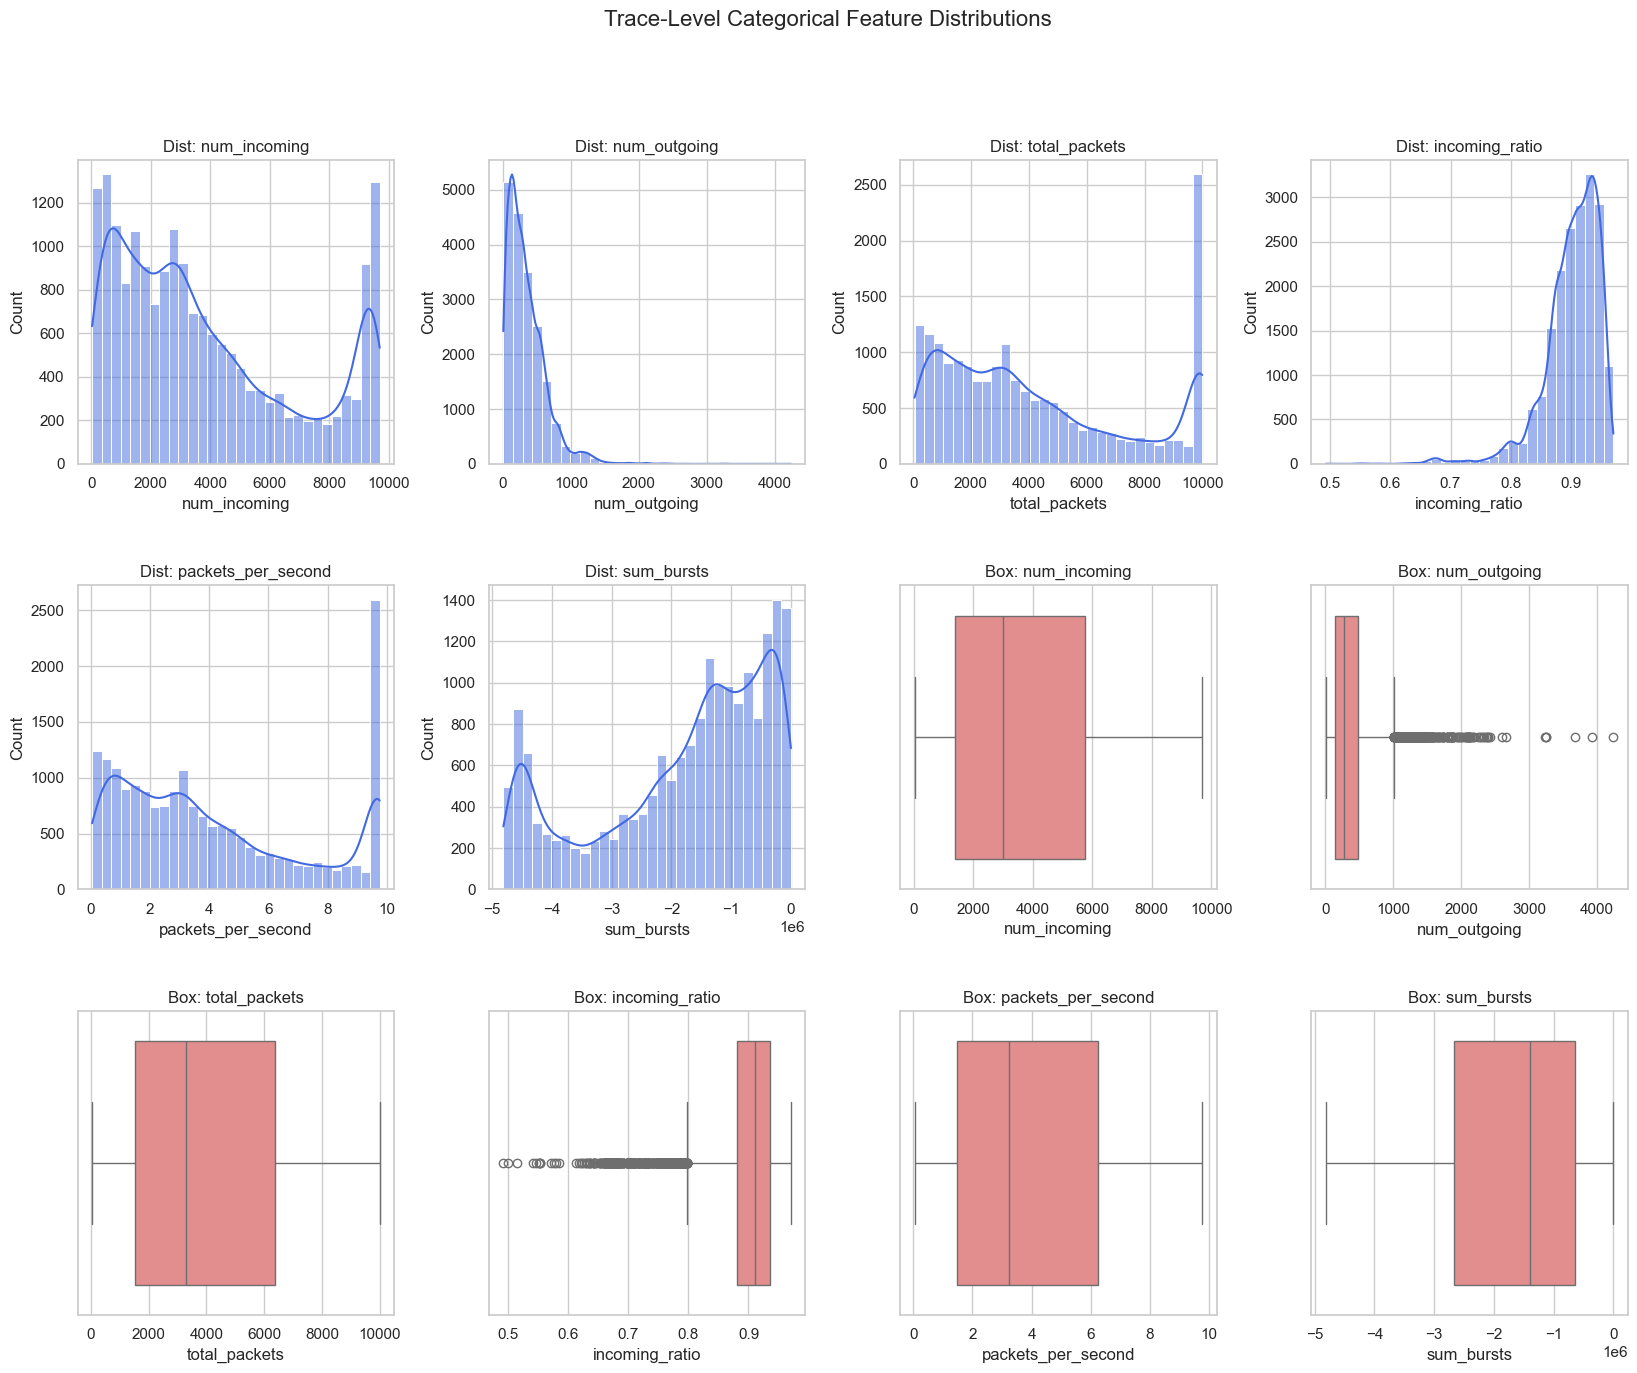

In [ ]:
# ============================================================
# Trace 단위 시각화 (Categorical)
# ============================================================

print("\n" + "=" * 80)
print("TRACE-LEVEL VISUALIZATION (Categorical)")
print("=" * 80)

# 시각화할 주요 Feature 선정 (ID 제외)
viz_features = ['num_incoming', 'num_outgoing', 'total_packets',
                'incoming_ratio', 'packets_per_second', 'sum_bursts']

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. 히스토그램 (분포 확인)

for i, feature in enumerate(viz_features):
    plt.subplot(3, 4, i+1)
    sns.histplot(trace_cat_df[feature], kde=True, bins=30, color='royalblue')
    plt.title(f'Dist: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

# 2. 박스플롯 (이상치 확인)

for i, feature in enumerate(viz_features):
    plt.subplot(3, 4, i+7) # 7번 위치부터 시작
    sns.boxplot(x=trace_cat_df[feature], color='lightcoral')
    plt.title(f'Box: {feature}')
    plt.xlabel(feature)

plt.suptitle('Trace-Level Categorical Feature Distributions', fontsize=16)
plt.show()